# 2487-2122 Machine Learning - Group Project 

# Group n. 3
**Team members**: Julian Beyerlein - 50881, Sara Boffa - 49673, Greta Miotto - 50523, Tara-sophia Tumbragel - 48333, Florentin Von Haugwitz - 48174

----

# **<a id="H&M Personalized Product Recommendation Models" style="color:#023e8a;">H&M Personalized Product Recommendation Models</a>**

![HM](https://upload.wikimedia.org/wikipedia/commons/5/53/H%26M-Logo.svg)

----

# **<a id="Content" style="color:#023e8a;">Table of Content</a>**

In this notebook, you will find **5 differrent sections**. Our final aim is to show the Machine Learning models we built and used in order to answer H&M Business Problem. The dataset we are going to used have been provided by H&M Group on *kaggle.com*. 

###  [**<span style="color:#023e8a;">1. Business_Problem </span>**](#Business_Problem) 
###  [**<span style="color:#023e8a;">2. Exploratory_Analysis </span>**](#Exploratory_Analysis)  
###  [**<span style="color:#023e8a;">3. Models </span>**](#Models)  
###  [**<span style="color:#023e8a;">4. Evaluation_Metrics </span>**](#Evaluation_Metrics) 
###  [**<span style="color:#023e8a;">5. Impact_analysis </span>**](#Impact_analysis)

----

## **<span id="Business_Problem" style="color:#023e8a;">1. Business_Problem</span>**

E-commerce is becoming an increasingly relevant channel for any fashion company. If this industry had worldwide revenues of about 480b in 2018, in 2019 this number increased to 545b in 2019 and the experts expect it to reach over 700b by the end of 2022. There are many reasons for this increase, from the pandemic that has accelerated this trend to consumer preferences that increasingly look to online channels. One thing is certain, though: companies like H&M can't pay attention to their online offerings and the customer experience their e-commerce provides. 

In order to improve the customer shopping experience, helping customers make the right choices and find the products they are looking for in the shortest possible time can be crucial to the success of a company's online channel. 
**Thanks to the huge amount of data collected on users browsing and purchases on H&M's website, it is therefore possible to build models that allow to predict which garments each customer might buy in the future**. 

Being able to **predict these items can bring numerous benefits** such as: 

-	**Improving the customer experience** during online shopping by going to recommend or highlight items that the individual is most interested in. 

- **Improve your targeted advertising strategy**. By predicting which garments an individual is most interested in buying, you can then go on to develop targeted marketing campaigns to induce and convince the consumer to buy the garment as soon as possible. 

-	**Improve the company's supply chain**. Forecasting means anticipating which items are most likely to run out and therefore preventing the product from being sold out in the warehouse. Moreover, this can also have positive implications for sustainability, since it can reduce returns, and therefor minimizes emissions from transportations. 

**Through the Machine Learning models** that we will describe in the following cells, **we will predict 12 items every customer could purchase in the next 7 days**. Thanks to the huge amount of data we have on the customers and on their past purchases, we can use different ML models in order to acquire the benefits we mentioned above. This allows us to build a business case and increase sales as the customer will be more inclined to buy certain products to our recommenations. 

------

## **<span id="Exploratory_Analysis" style="color:#023e8a;">1. Imports, Load, Clean and Split Data</span>**


 #### **<span id="Datasets" style="color:#023e8a;">1. Imports</span>** 

In [ ]:
!pip install -U scipy
!pip install lightfm
!pip install -U tensorflow-recommenders

In [2]:
import pandas as pd
import numpy as np

import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.contingency import crosstab
from datetime import timedelta

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, utils
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model
from typing import Dict, Text
import tensorflow_recommenders as tfrs

from lightfm import LightFM
from lightfm.data import Dataset
import tqdm

import warnings
warnings.filterwarnings("ignore")

 #### **<span id="Datasets" style="color:#023e8a;">2. Load Data and print an overview</span>** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd ./drive/MyDrive/NovaSBE/Kurse/MachineLearning/Project/Colab
%ls

In [4]:
df_transactions_load = pd.read_parquet("transactions_big_sample.parquet")

# Only take customers into account that bought more than 12 articles
# Only take 45000 transactions in order for the laptop to run similaritiy matrices in memory
value_count_customers = df_transactions_load.customer_id.value_counts()
df_transactions = df_transactions_load[df_transactions_load.customer_id.isin(value_count_customers.index[value_count_customers.gt(12)])].sort_values("customer_id").head(45000)
unique_articles = df_transactions.article_id.unique()
unique_customers = df_transactions.customer_id.unique()

df_articles = pd.read_parquet("articles.parquet")
df_articles = df_articles[df_articles["article_id"].isin(unique_articles)].copy() # Only look at articles with a transaction history

df_customers = pd.read_parquet("customers.parquet")
df_customers = df_customers[df_customers["customer_id"].isin(unique_customers)].copy()# Only look at customers with a transaction history

print("Number of customers", df_customers.customer_id.nunique())
print("Number of articles", df_articles.article_id.nunique())
print("Number of transactions", df_transactions.shape[0])
print("Number of unique dates", df_transactions.t_dat.nunique())

Number of customers 1891
Number of articles 22526
Number of transactions 45000
Number of unique dates 734


 #### **<span id="Datasets" style="color:#023e8a;">3. Clean Data</span>** 

In [5]:
#Transactions
df_transactions['t_dat'] = pd.to_datetime(df_transactions['t_dat'], format="%Y-%m-%d")
df_transactions['sales_channel_id'] = df_transactions['sales_channel_id'].astype(str) #change sales channel dtype
df_transactions['month'] = pd.to_datetime(df_transactions['t_dat']).dt.month
df_transactions['year'] = pd.to_datetime(df_transactions['t_dat']).dt.year
df_transactions['t_dat'] = pd.to_datetime(df_transactions['t_dat']) #Create datetime format
df_transactions["article_id"] = df_transactions["article_id"].astype(str)

#Customer
df_customers['fashion_news_frequency'] = df_customers['fashion_news_frequency'].replace('NONE','None')
df_customers['age'] = df_customers['age'].fillna(-1)
df_customers['FN'] = df_customers['FN'].fillna(0)
df_customers['Active'] = df_customers['Active'].fillna(0)
df_customers["age_interval"] = pd.cut(df_customers["age"], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90], labels=["10-20","20-30", "30-40","40-50", "50-60", "60-70", "70-80", "80-90"])

# Articles
df_articles["article_id"] = df_articles["article_id"].astype(str)

 #### **<span id="Datasets" style="color:#023e8a;">4. Split and Merge Data </span>** 

**Reasoning:**:

 We decided to create two variables: a dependent variable (X) and independent variable (y), since the goal of our model is to make an accurate prediction on which 10 articles a single customer is likely to buy within the next 7 days, based on previous purchases.

Given that we only have historical data available, we decided to split the set into the dependent set X, which will serve as the foundation of the model, and into our independent set y, which serves as a control mechanism to evaluate the accuracy of correctly predicted clothing articles.

Hence, our data is sorted by date and split into X and y from a specific date onwards.

In [6]:
df_transactions.sort_values("t_dat", inplace=True) # Sort the data by date
df_transactions.reset_index(drop=True, inplace=True) # Reset for iloc function later
last_day = df_transactions.iloc[-1, 0] # Get the last date
seven_days_before_last = last_day - timedelta(7) # Get timedelta of 7 days

split_time = df_transactions[df_transactions["t_dat"] == seven_days_before_last].last_valid_index() #

X = df_transactions.iloc[:split_time, :]
y = df_transactions.iloc[split_time:, :]

print(X.shape,y.shape)

# New merge for analyses
X_analyses = X.merge(df_customers, how="left", on="customer_id")
X_analyses = X_analyses.merge(df_articles, how="left", on="article_id")

y_analyses = y.merge(df_customers, how="left", on="customer_id")
y_analyses = y_analyses.merge(df_articles, how="left", on="article_id")

(44675, 7) (325, 7)


 #### **<span id="Datasets" style="color:#023e8a;">5. Customer Article Matrix</span>** 

Calculating the sparse matrices of customer and article to see which customer bought which article

In [7]:
(avals, xvals), count = crosstab(X_analyses.customer_id, X_analyses.article_id)
df_customer_article_X = pd.DataFrame(count, index=avals, columns=xvals)

(avals, xvals), count = crosstab(y_analyses.customer_id, y_analyses.article_id)
df_customer_article_y = pd.DataFrame(count, index=avals, columns=xvals)

In [8]:
# Getting last article per customer in X data set
df_last_articles = X_analyses.sort_values("t_dat", ascending=False)
df_last_articles.drop_duplicates("customer_id", inplace=True)
df_last_articles.set_index("customer_id", verify_integrity=True, inplace=True)

## **<span id="Exploratory_Analysis" style="color:#023e8a;">2. Exploratory_Analysis</span>**

After defining our Business problem in the section above, we performed some exploratory analysis on our datasets in other to garther more information on the e-commerce costumers, the items they bought in the past, the avarage spending per costumer etc... and highlight some patterns in the data that might come useful later during the building phase of our ML models.

--

In this section you will find: 

*   [<span style="color:#023e8a;">1. Datasets </span>](#Datasets) 
*   [<span style="color:#023e8a;">2. Articles </span>](#Articles)
*   [<span style="color:#023e8a;">3. Customers </span>](#Customers) 
*   [<span style="color:#023e8a;">4. Data_Exploration </span>](#Data_Exploration)
*   [<span style="color:#023e8a;">5. Additional_Analysis </span>](#Additional_Analysis)

--


 #### **<span id="Datasets" style="color:#023e8a;">1. Datasets</span>** 


H&M datasets deal with multiple types of data, from simple data such as item type and customer age, to text data and product description. 

The files we will use are three: 

- **articles.csv** - detailed metadata for each article_id available for purchase
    Articles data desctiption:
    
> `article_id` **<span style="color:#023e8a;">: A unique identifier of every article.</span>**  
> `product_code`, `prod_name` **<span style="color:#023e8a;">: A unique identifier of every product and its name (not the same).</span>**  
> `product_type`, `product_type_name` **<span style="color:#023e8a;">: The group of product_code and its name</span>**  
> `graphical_appearance_no`, `graphical_appearance_name` **<span style="color:#023e8a;">: The group of graphics and its name</span>**  
> `colour_group_code`, `colour_group_name` **<span style="color:#023e8a;">: The group of color and its name</span>**  
> `perceived_colour_value_id`, `perceived_colour_value_name`, `perceived_colour_master_id`, `perceived_colour_master_name` **<span style="color:#023e8a;">: The added color info</span>**  
> `department_no`, `department_name`: **<span style="color:#023e8a;">: A unique identifier of every dep and its name</span>**  
> `index_code`, `index_name`: **<span style="color:#023e8a;">: A unique identifier of every index and its name</span>**  
> `index_group_no`, `index_group_name`: **<span style="color:#023e8a;">: A group of indeces and its name</span>**  
> `section_no`, `section_name`: **<span style="color:#023e8a;">: A unique identifier of every section and its name</span>**  
> `garment_group_no`, `garment_group_name`: **<span style="color:#023e8a;">: A unique identifier of every garment and its name</span>**  
> `detail_desc`: **<span style="color:#023e8a;">: Details</span>**  

- **customers.csv** - metadata for each customer_id in dataset.

    Customers data description:
> `customer_id` **<span style="color:#023e8a;">: A unique identifier of every customer</span>**  
> `FN` **<span style="color:#023e8a;">: 1 or missed </span>**  
> `Active` **<span style="color:#023e8a;">: 1 or missed</span>**  
> `club_member_status` **<span style="color:#023e8a;">: Status in club</span>**  
> `fashion_news_frequency` **<span style="color:#023e8a;">: How often H&M may send news to customer</span>**  
> `age` **<span style="color:#023e8a;">: The current age</span>**  
> `postal_code` **<span style="color:#023e8a;">: Postal code of customer</span>** 

- **transactions_train.csv** - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. 

    Transaction data description:
> `t_dat` **<span style="color:#023e8a;">: A unique identifier of every customer</span>**  
> `customer_id` **<span style="color:#023e8a;">: A unique identifier of every customer </span>**  **<span style="color:#FF0000;">(in </span>** `customers` **<span style="color:#FF0000;"> table)</span>**  
> `article_id` **<span style="color:#023e8a;">: A unique identifier of every article</span>**  **<span style="color:#FF0000;">(in </span>** `articles` **<span style="color:#FF0000;"> table)</span>**  
> `price` **<span style="color:#023e8a;">: Price of purchase</span>**  
> `sales_channel_id` **<span style="color:#023e8a;">: 1 or 2</span>** 


#### **<span id="Articles" style="color:#023e8a;">2. Articles</span>** 

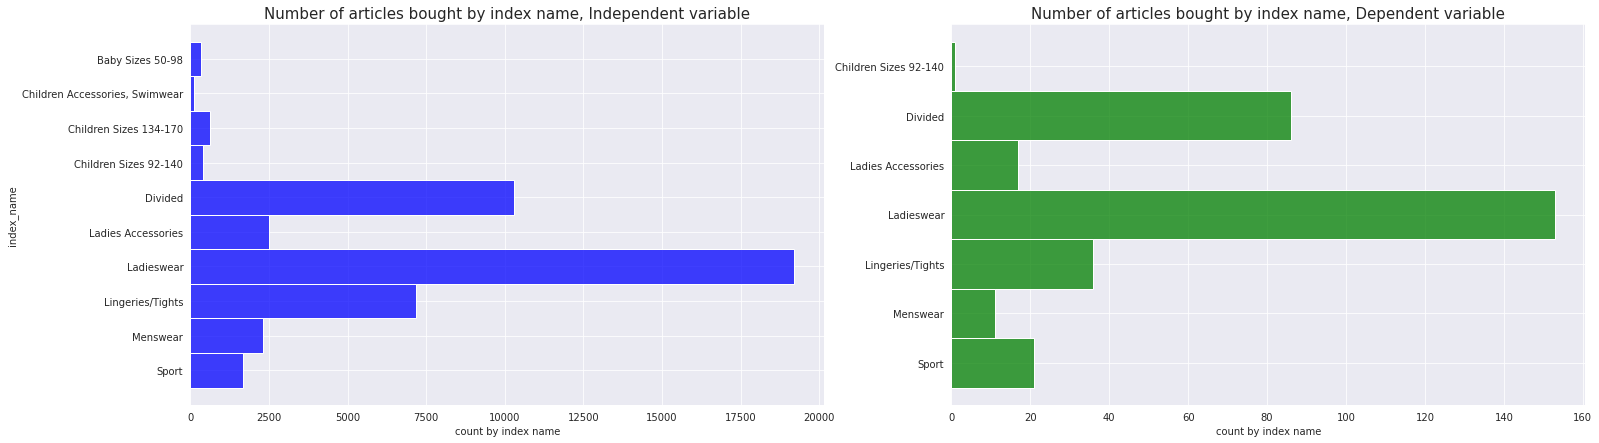

In [9]:
#Article by Index Name
articles_x = X_analyses.sort_values('index_name')
articles_y = y_analyses.sort_values('index_name')

sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
ax1.set_title("Number of articles bought by index name, Independent variable", fontsize = 15)
sns.histplot(data=articles_x, y='index_name', ax = ax1, color="blue")
ax1.set_xlabel('count by index name')
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()

ax2.set_title("Number of articles bought by index name, Dependent variable", fontsize = 15)
sns.histplot(data=articles_y, y='index_name', ax = ax2, color = 'green')
ax2.set_ylabel('')
ax2.set_xlabel('count by index name')
x0,x1 = ax2.get_xlim()

plt.show()

The most sold articles are ladieswear, while the least sold are childrenswear & swimmwear articles. Across the dependent and independent set we cannot detect any significant structural differences.

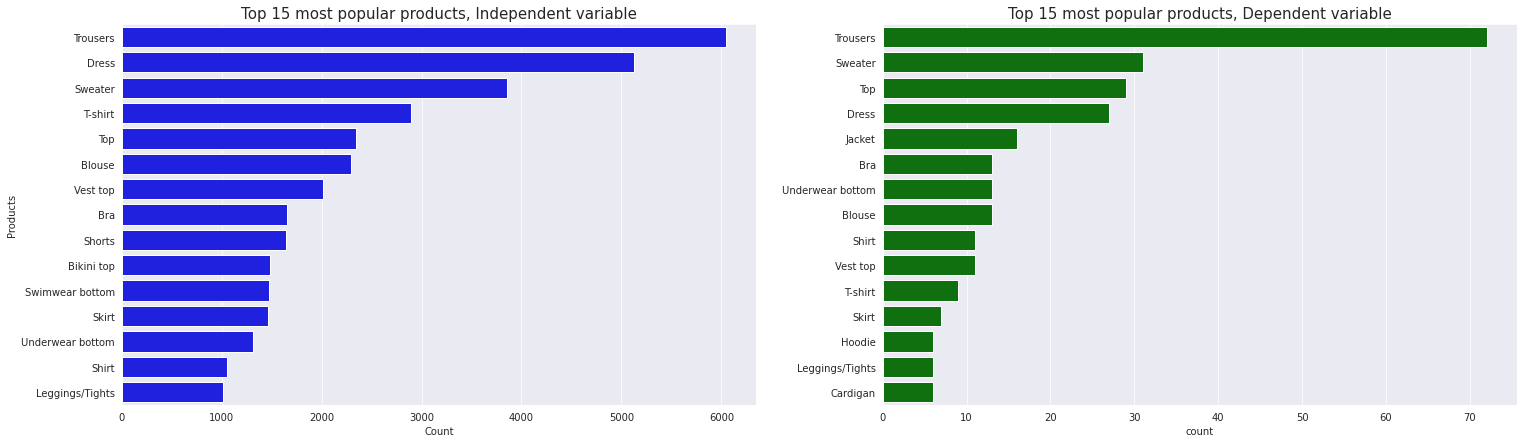

In [10]:
# Top 15 most popular products
most_popular_x = X_analyses['product_type_name'].value_counts().reset_index()
most_popular_x = most_popular_x.sort_values(by= 'product_type_name', ascending=False).head(15)

most_popular_y = y_analyses['product_type_name'].value_counts().reset_index()
most_popular_y = most_popular_y.sort_values(by= 'product_type_name', ascending=False).head(15)

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
ax1.set_title("Top 15 most popular products, Independent variable", fontsize = 15)
sns.barplot(data=most_popular_x, x='product_type_name', y= 'index', ax = ax1, 
            color = 'blue', orient = 'h')
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax1.set_ylabel("Products")
ax1.set_xlabel("Count")

ax2.set_title("Top 15 most popular products, Dependent variable", fontsize = 15)
sns.barplot(data=most_popular_y, x='product_type_name', y= 'index', ax = ax2, 
            color = 'green', orient = 'h')
x0,x1 = ax2.get_xlim()
x0,x1 = ax2.get_xlim()
ax2.set_ylabel("")
ax2.set_xlabel("count")

plt.show()

When looking at individual products, the most sold ones are sweaters and trousers across the dependent and independent set. Similarly, we cannot detect any significant structural differences that could bias our model.

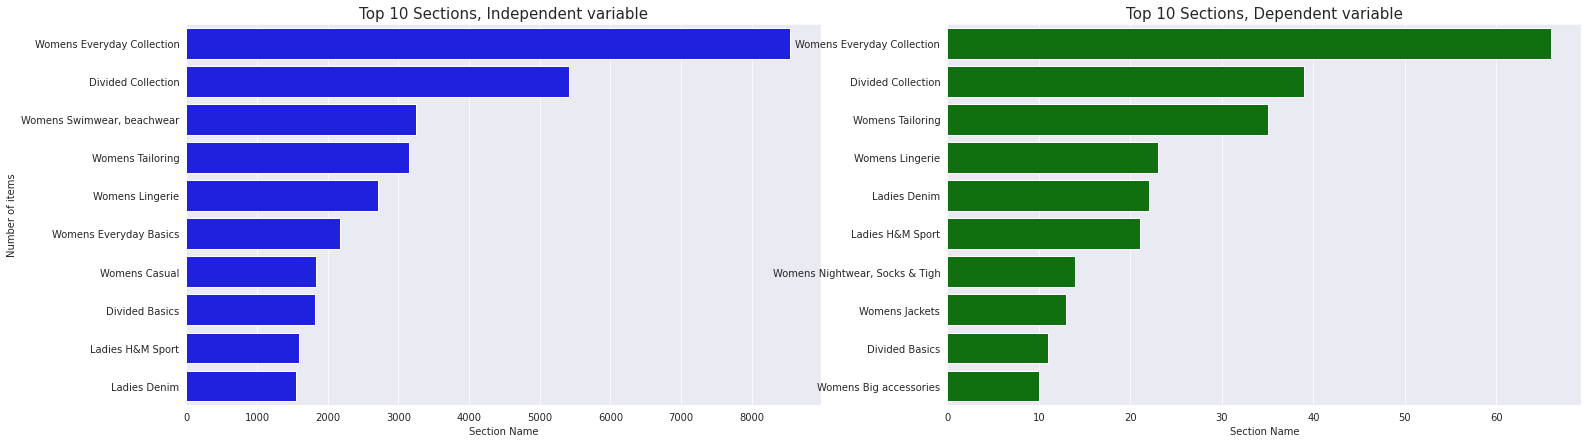

In [11]:
# Items distribution over different Sections
sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))

ax1.set_title("Top 10 Sections, Independent variable", fontsize = 15)
sns.countplot(y = 'section_name', data = X_analyses, ax=ax1,
              order = X_analyses['section_name'].value_counts().iloc[:10].index, color= 'blue')
ax1.set_ylabel("Number of items")
ax1.set_xlabel("Section Name")

ax2.set_title("Top 10 Sections, Dependent variable", fontsize = 15)
sns.countplot(y = 'section_name', data = y_analyses, ax=ax2,
              order = y_analyses['section_name'].value_counts().iloc[:10].index, color= 'green')
ax2.set_ylabel("")
ax2.set_xlabel("Section Name")

plt.show()

The most popular section is Womens Everyday collection, followed by Divided section. This trend is the same in the dependent and independent set.

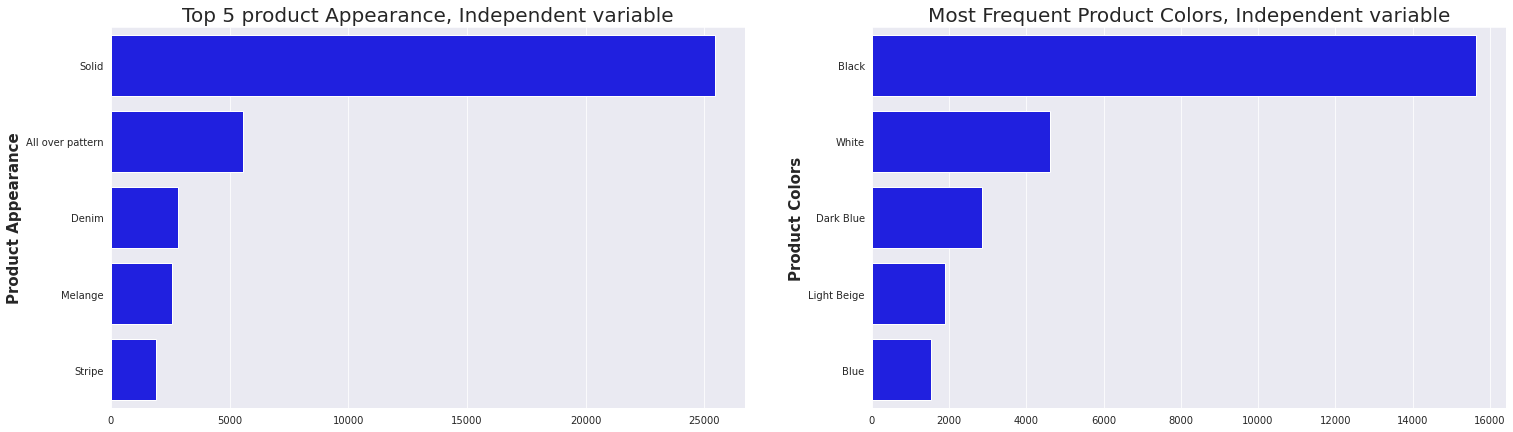

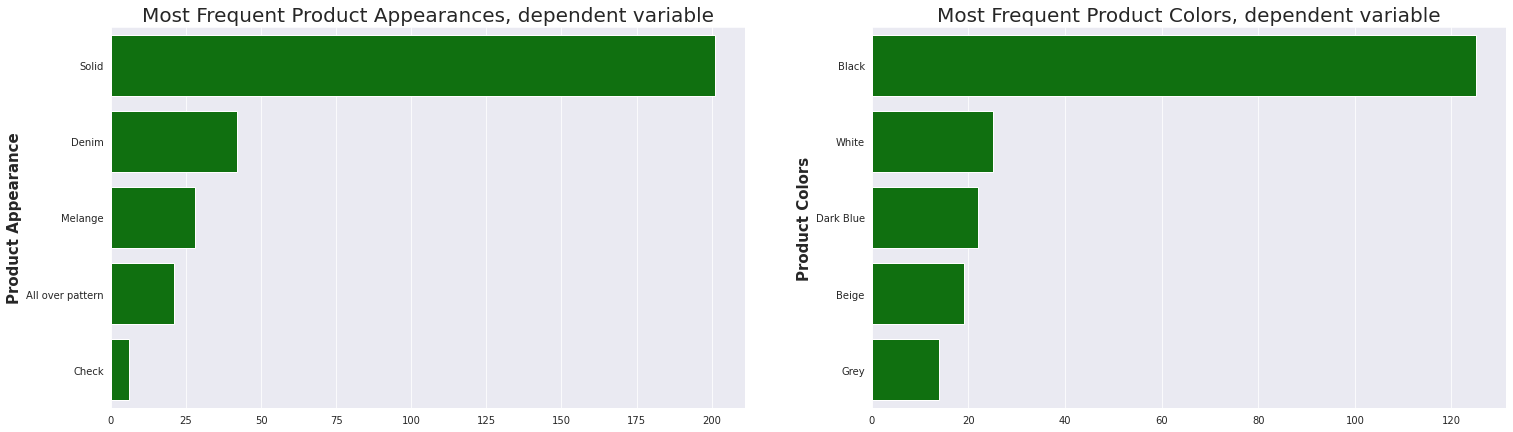

In [12]:
# Apperance & Colours

# Apperance
prod_appearance_x = X_analyses["graphical_appearance_name"].value_counts().reset_index().head(5)
prod_appearance_y = y_analyses["graphical_appearance_name"].value_counts().reset_index().head(5)
#total_prod_appearances_x = dt_articles["graphical_appearance_name"].nunique()

#Colours
prod_color_x = X_analyses["colour_group_name"].value_counts().reset_index().head(5)
prod_color_y = y_analyses["colour_group_name"].value_counts().reset_index().head(5)
#total_prod_color = dt_articles["colour_group_name"].nunique()

# Plot Train set
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
ax1.set_title('Top 5 product Appearance, Independent variable', fontsize=20)
sns.barplot(data=prod_appearance_x, x="graphical_appearance_name", y="index", ax=ax1, color = 'blue')
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax1.set_xlabel('')
ax1.set_ylabel("Product Appearance", size=15, weight="bold")

ax2.set_title('Most Frequent Product Colors, Independent variable', fontsize=20)
sns.barplot(data=prod_color_x, x="colour_group_name", y="index", ax=ax2, color = 'blue')
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
ax2.set_ylabel("Product Colors", size = 15, weight="bold")
ax2.set_xlabel('')
plt.show()

# Plot Test set
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
ax1.set_title('Most Frequent Product Appearances, dependent variable', fontsize=20)
sns.barplot(data=prod_appearance_y, x="graphical_appearance_name", y="index", ax=ax1, color = 'green')
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
ax1.set_xlabel('')
ax1.set_ylabel("Product Appearance", size=15, weight="bold")

ax2.set_title('Most Frequent Product Colors, dependent variable', fontsize=20)
sns.barplot(data=prod_color_y, x="colour_group_name", y="index", ax=ax2, color = 'green')
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
ax2.set_ylabel("Product Colors", size = 15, weight="bold")
ax2.set_xlabel('')
plt.show()

Simple patterns are the most popular, with Solid being the most sold. Black is the most popular color, followed by dark blue and white.

#### **<span id="Customers" style="color:#023e8a;">3. Customers</span>** 

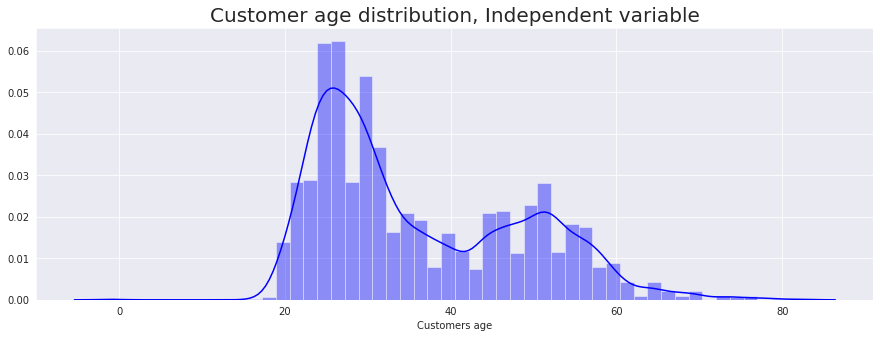

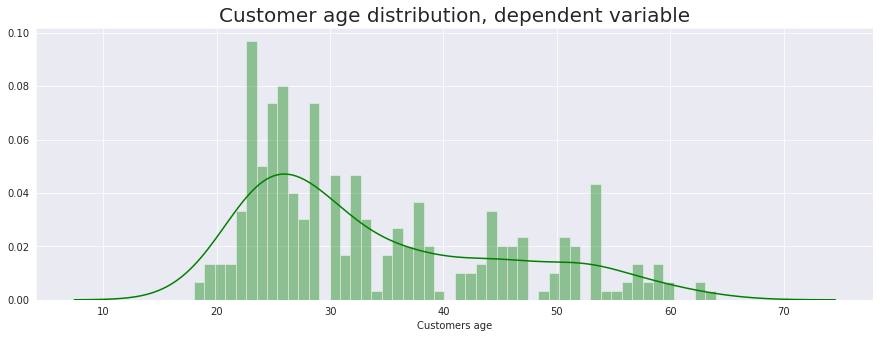

In [13]:
#Customer age distribution

f, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(X_analyses["age"], bins=50, color='blue')
ax.set_xlabel('Customers age')
ax.set_ylabel('')
plt.title("Customer age distribution, Independent variable", fontsize=20)
plt.show()

f, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(y_analyses["age"], bins=50, color='green')
ax.set_xlabel('Customers age')
ax.set_ylabel('')
plt.title("Customer age distribution, dependent variable", fontsize=20)
plt.show()

The clients' age distribution is similar in the dependent and independent set. In fact, the highest amount of customers are in their mid-twenties. Clients tend to start buying really young (first peak at 17-18). The age trend starts decreasing when consumers are in their thirties, with the lowest point in their forties and a weak rise in their fifties.

In [14]:
# Postal Code
data_postal = df_customers.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,age_interval
325,2c29ae653a9282cce4151bd87643c907644e09541abc28...,5,5,5,5,5,5,5
795,6cb80dbeaf4d364790fb43f23a5eca263d9532d0938c63...,2,2,2,2,2,2,2
1103,93e958c3c74d6c0f5b8f2c88c028469dad7f295b8866f3...,2,2,2,2,2,2,2
1135,96c529a5013855d2f2a9572e41b5c0b16fedc0c2ec9cdb...,2,2,2,2,2,2,2
74,0a540444a3a9613c0b3aacb5abb2810ea1e6204e725422...,2,2,2,2,2,2,2


There is an abnormal number of customers with the same postal code. One has 120303, it might be an encoded NaN address or a distribution center / pickup location. However, this does not affect our model, as this feature is not included.


--

#### **<span id="Data_Exploration" style="color:#023e8a;">4. Data_Exploration</span>** 

In [15]:
#### Check for NULL values
print("Missing values within transactions dataset:")
print(df_transactions.isna().sum())

Missing values within transactions dataset:
t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
month               0
year                0
dtype: int64


In [16]:
# Merge subset dataframes for further analyses of time series
articles_for_merge = df_articles[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]
df_transactions_load["article_id"] = df_transactions_load["article_id"].astype(str)
articles_for_merge_time_series = df_transactions_load[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

In [17]:
# Merge of data set for other analyses
articles_for_merge_X = X_analyses[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')
articles_for_merge_y = y_analyses[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

In [18]:
# Create new dataframes for further analyses
basket_X = X_analyses.groupby("customer_id").agg({'article_id':'count', 
                                                  'price': 'sum'}).reset_index()
basket_X.columns = ["customer_id", "units", "order_price"]

basket_y = y_analyses.groupby("customer_id").agg({'article_id':'count', 
                                                  'price': 'sum'}).reset_index()
basket_y.columns = ["customer_id", "units", "order_price"]

In [19]:
print("Maximum Price Train set is:", round(articles_for_merge_X["price"].max(),4), "\n" +
      "Minimum Price Train set is:", round(articles_for_merge_X["price"].min(),5), "\n" +
      "Average Price Train set is:", round(articles_for_merge_X["price"].mean(),4))

print("Maximum Price Test set is:", round(articles_for_merge_y["price"].max(),4), "\n" +
      "Minimum Price Test set is:", round(articles_for_merge_y["price"].min(),5), "\n" +
      "Average Price Test set is:", round(articles_for_merge_y["price"].mean(),4))

Maximum Price Train set is: 0.422 
Minimum Price Train set is: 0.00042 
Average Price Train set is: 0.0288
Maximum Price Test set is: 0.1356 
Minimum Price Test set is: 0.00269 
Average Price Test set is: 0.0365


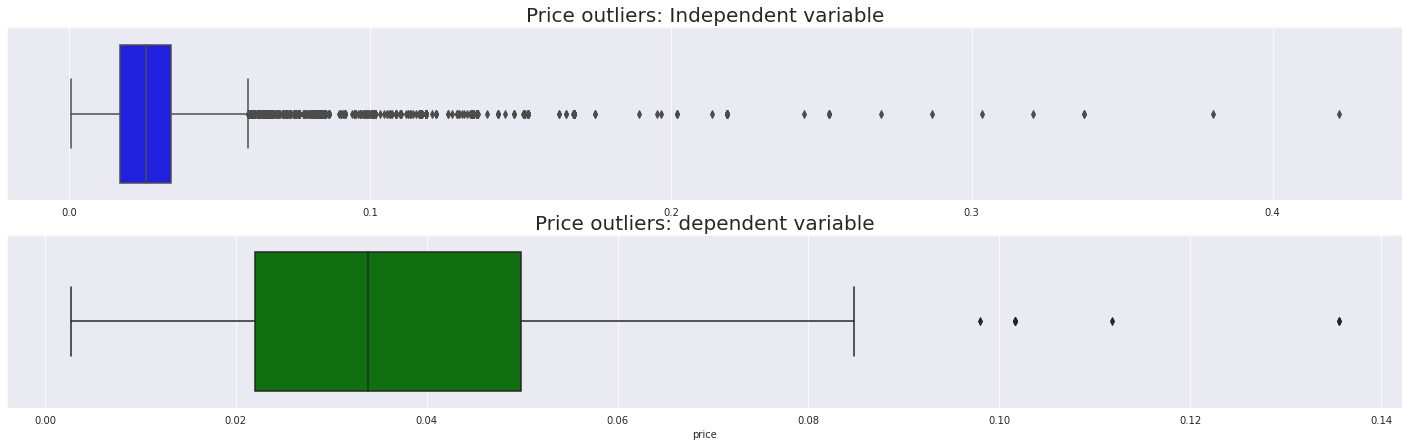

In [20]:
# Outliers
sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25,7))
ax1.set_title('Price outliers: Independent variable', size=20)
ax2.set_title('Price outliers: dependent variable', size=20)

sns.boxplot(data=X_analyses, x='price', ax=ax1, color='blue')
sns.boxplot(data=y_analyses, x='price', ax=ax2, color='green')

ax1.set_xlabel('')
ax2.set_xlabel('price')

plt.show()

Prices are coherent across both data sets. 

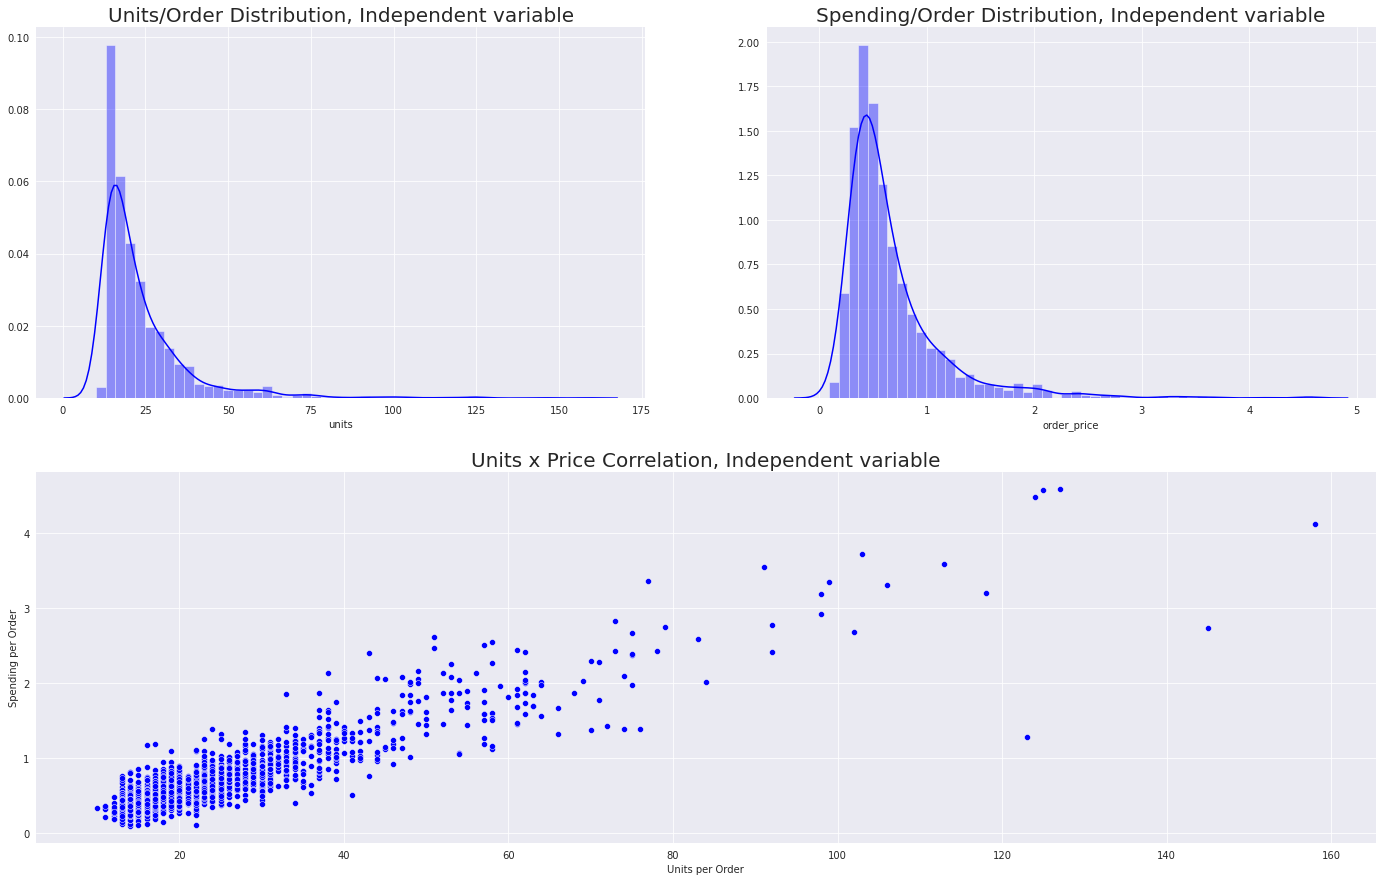

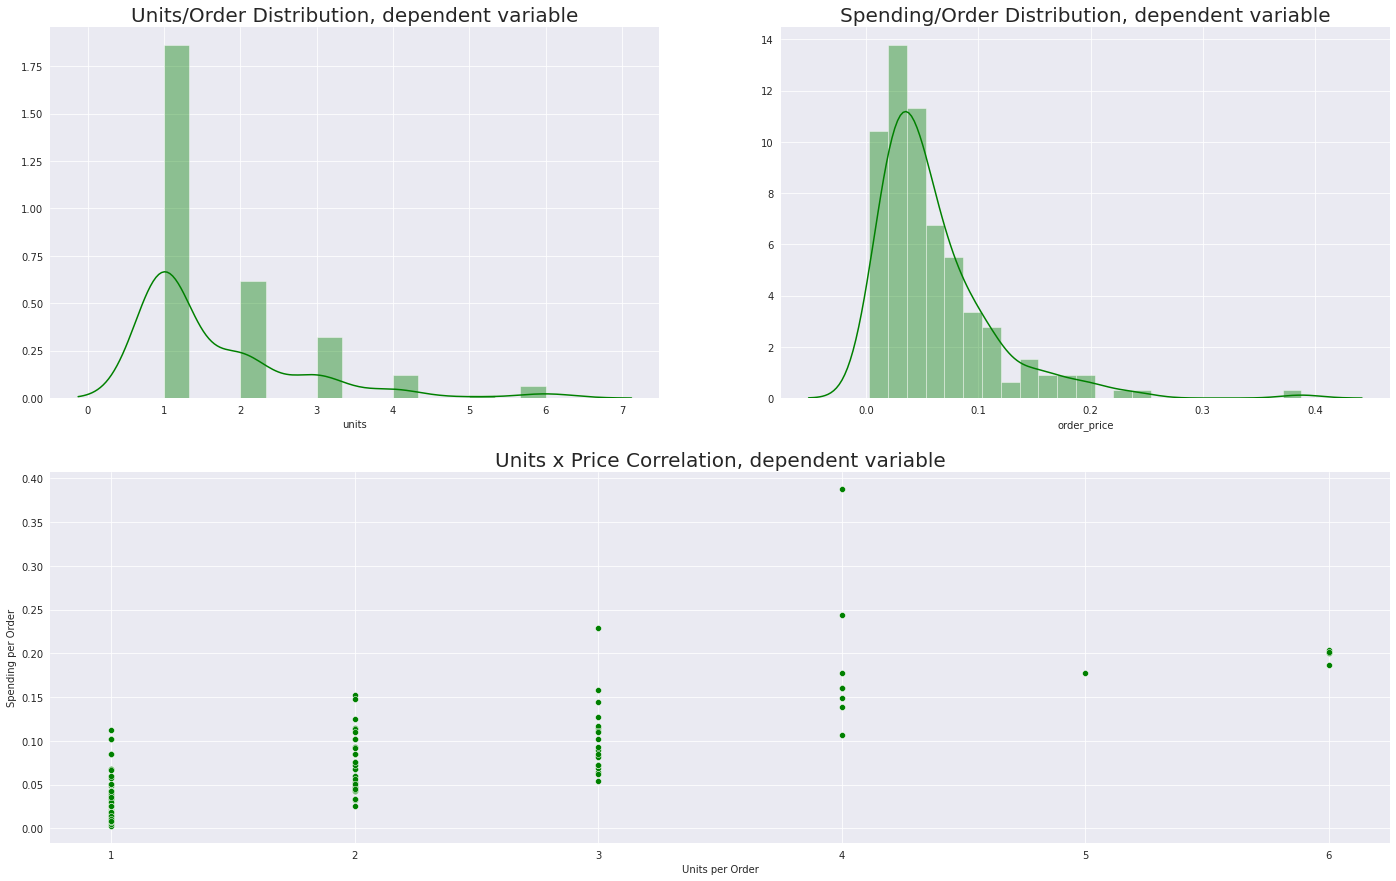

In [21]:
# Order & Spending behaviour on Train set
plt.figure(figsize=(24, 15))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.distplot(basket_X["units"], ax=ax1, color='blue')
ax1.set_title("Units/Order Distribution, Independent variable", size=20)
ax1.set_ylabel("")

sns.distplot(basket_X["order_price"], ax=ax2, color='blue')
ax2.set_title("Spending/Order Distribution, Independent variable", size=20)
ax2.set_ylabel("")

sns.scatterplot(data=basket_X, x="units", y="order_price", color='blue', 
                legend=None, ax=ax3)
ax3.set_title("Units x Price Correlation, Independent variable", size=20)
ax3.set_ylabel("Spending per Order")
ax3.set_xlabel("Units per Order")

sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
              
              
# Order & Spending behaviour on Test set              
plt.figure(figsize=(24, 15))

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.distplot(basket_y["units"], ax=ax1, color='green')
ax1.set_title("Units/Order Distribution, dependent variable", size=20)
ax1.set_ylabel("")

sns.distplot(basket_y["order_price"], ax=ax2, color='green')
ax2.set_title("Spending/Order Distribution, dependent variable", size=20)
ax2.set_ylabel("")

sns.scatterplot(data=basket_y, x="units", y="order_price", color='green', 
                legend=None, ax=ax3)
ax3.set_title("Units x Price Correlation, dependent variable", size=20)
ax3.set_ylabel("Spending per Order")
ax3.set_xlabel("Units per Order")

sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

In terms of purchase behaviour, the majority of customers purchase few products. Naturally, total amount spent in relaion to order quantity is positively correlated. The average order has around 23 units and costs ~0.649.
 

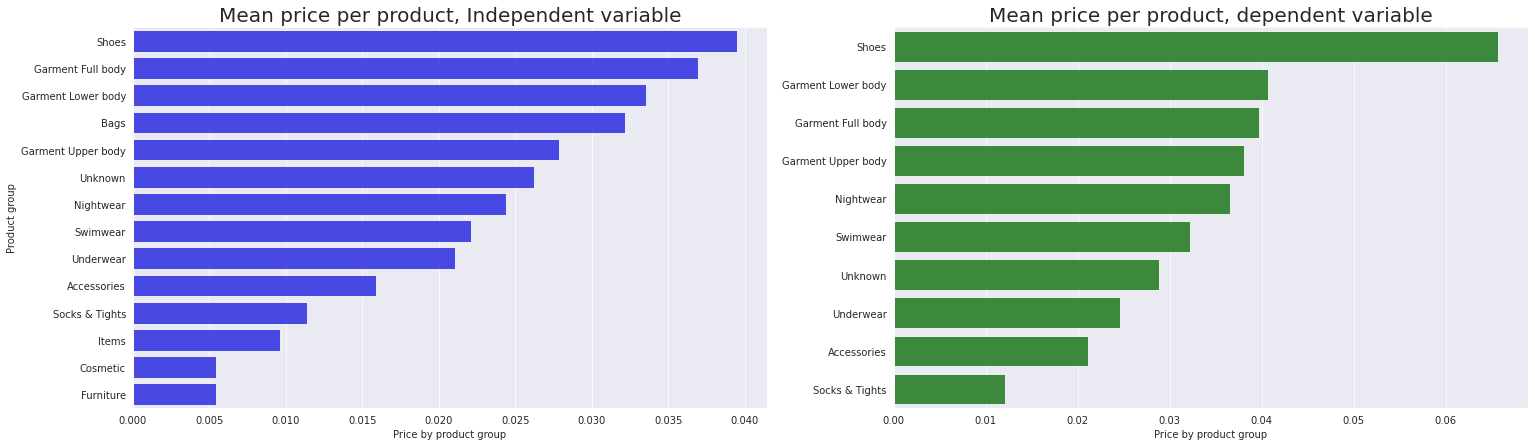

In [22]:
# Mean price across products
articles_index_X = articles_for_merge_X[['product_group_name', 'price']].groupby('product_group_name').mean().sort_values(by='price', ascending=False)
articles_index_y = articles_for_merge_y[['product_group_name', 'price']].groupby('product_group_name').mean().sort_values(by='price', ascending=False)


sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,7))
sns.barplot(x=articles_index_X.price, ax=ax1, y=articles_index_X.index, color='blue', alpha=0.8)
sns.barplot(x=articles_index_y.price, ax=ax2, y=articles_index_y.index, color='green', alpha=0.8)

ax1.set_xlabel('Price by product group')
ax1.set_ylabel('Product group')
ax2.set_xlabel('Price by product group')
ax2.set_ylabel('')

ax1.set_title("Mean price per product, Independent variable", size=20)
ax2.set_title("Mean price per product, dependent variable", size=20)

plt.show()

In the independent set, we can see that bags and shoes are the products with the highest mean price. When looking at the y set, the bags category is not included in the dataset. 

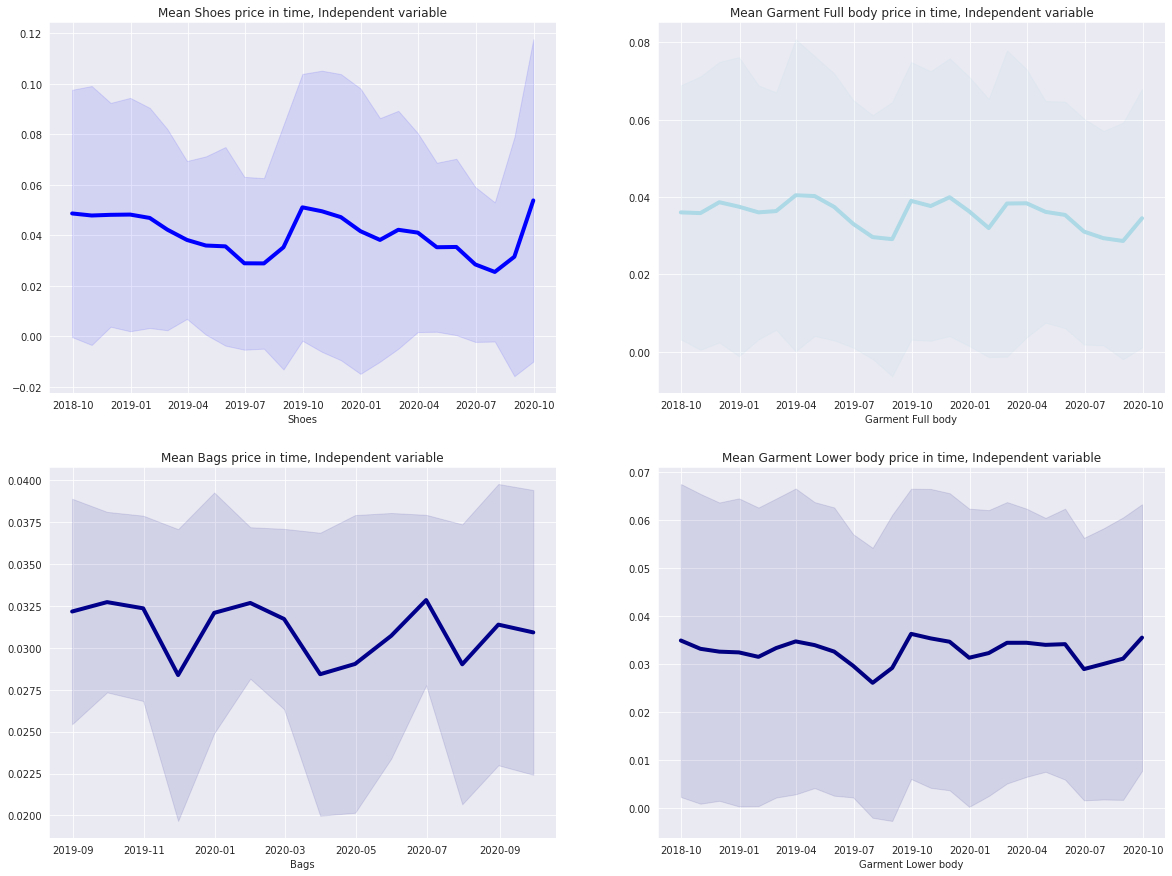

In [23]:
# Prices development for Top 4 products
product_list = ['Shoes', 'Garment Full body', 'Bags', 'Garment Lower body']
k = 0
colors = ["blue", "lightblue", "darkblue", "navy", "aliceblue"]
f, ax = plt.subplots(2, 2, figsize=(20, 15))
for i in range(2):
    for j in range(2):
        try:
            product = product_list[k]
            articles_for_merge_product = articles_for_merge_time_series[articles_for_merge_time_series.product_group_name == product_list[k]]
            series_mean = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).mean().fillna(0)
            series_std = articles_for_merge_product[['t_dat', 'price']].groupby(pd.Grouper(key="t_dat", freq='M')).std().fillna(0)
            ax[i, j].plot(series_mean, linewidth=4, color=colors[k])
            ax[i, j].fill_between(series_mean.index, (series_mean.values-2*series_std.values).ravel(), 
                             (series_mean.values+2*series_std.values).ravel(), color=colors[k], alpha=.1)
            ax[i, j].set_title(f'Mean {product_list[k]} price in time, Independent variable')
            ax[i, j].set_xlabel('month')
            ax[i, j].set_xlabel(f'{product_list[k]}')
            k += 1
        except IndexError:
            ax[i, j].set_visible(False)
plt.show()

When looking at price development of the top 4 products, we can see that shoes and upper/lower body garments remained quite stable, while bags dropped significantly over the observed time frame. This also explains why bags are not within the top 15 products in terms of mean price in our dependent variable, since we split our X and y on a specific timestamp.

--

#### **<span id="Additional_Analysis" style="color:#023e8a;">5. Additional_Analysis</span>** 

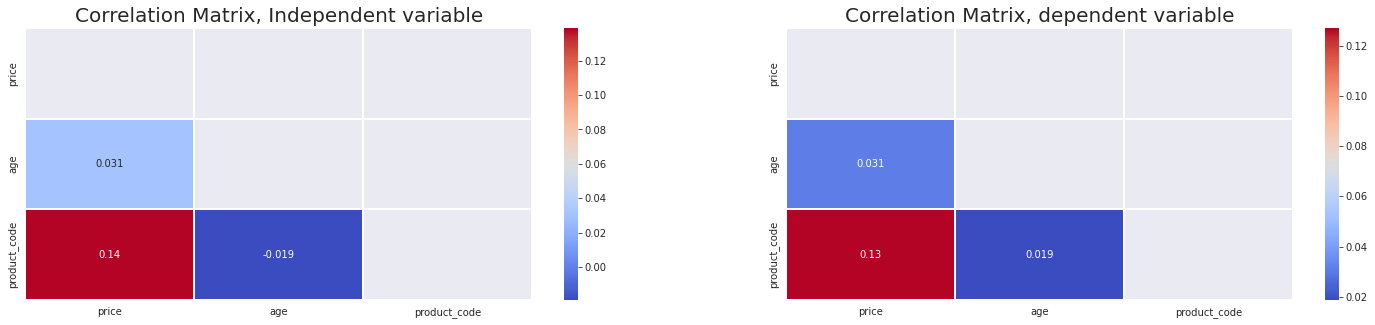

In [24]:
# Correlations

from pandas.plotting import scatter_matrix


f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,5))

corr_X = X_analyses[["price", "age", "product_code",]].corr()
corr_y = y_analyses[["price",  "age", "product_code",]].corr()

# Generate a mask for the upper triangle
mask_X = np.triu(np.ones_like(corr_X, dtype=bool))
mask_y = np.triu(np.ones_like(corr_y, dtype=bool))

#Plot Correlation Heatmap
sns.heatmap(corr_X, ax=ax1, annot = True, mask = mask_X, linewidths = 1, cmap = 'coolwarm')
sns.heatmap(corr_y, ax=ax2, annot = True, mask = mask_y, linewidths = 1, cmap = 'coolwarm')


ax1.set_title("Correlation Matrix, Independent variable", size=20)
ax2.set_title("Correlation Matrix, dependent variable", size=20)

plt.show()

A heatmap of the correlation between selected product feature shows that there are no significant differences between the two sets. In fact, in both variables the higher correlation is between the products and the price, and the lowest correlation is between products and customers' age.

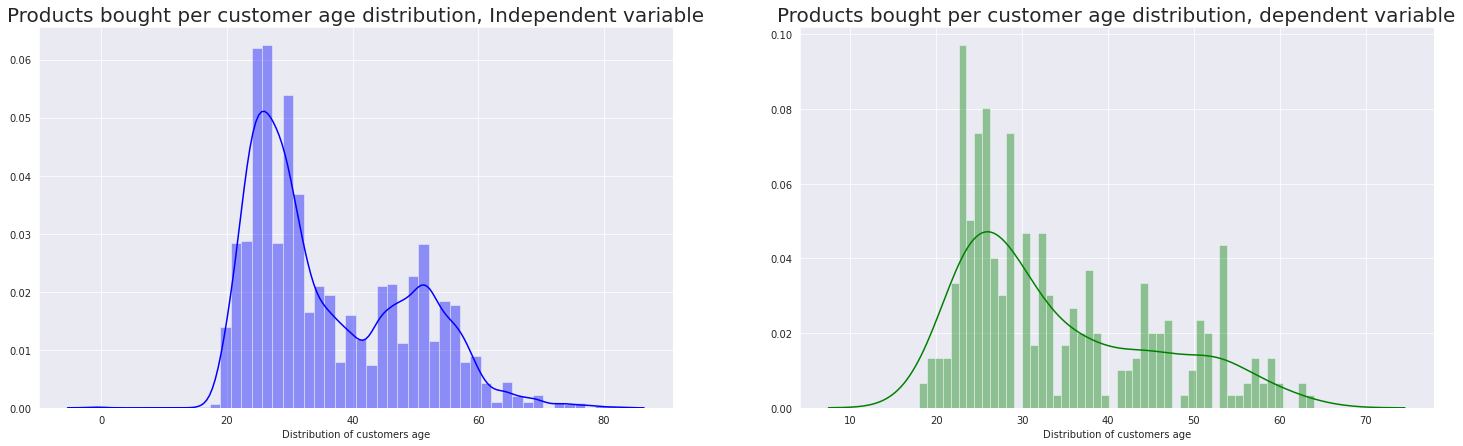

In [25]:
# Count of products bought, distributed by customer age (bins of 2 years)

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
ax1.set_title("Products bought per customer age distribution, Independent variable", size=20)
sns.distplot(X_analyses["age"], bins=50, ax=ax1, color='blue')
ax1.set_xlabel('Distribution of customers age')
ax1.set_ylabel('')

ax2.set_title("Products bought per customer age distribution, dependent variable", size=20)
sns.distplot(y_analyses["age"], bins=50, ax=ax2, color='green')
ax2.set_xlabel('Distribution of customers age')
ax2.set_ylabel('')

plt.show()

Similarly to an analysis displayed above, this graph shows the number of items bought by customers, distributed by age. Following the line trend, it is possible to see that the dependent and the independent set have a similar distribution.

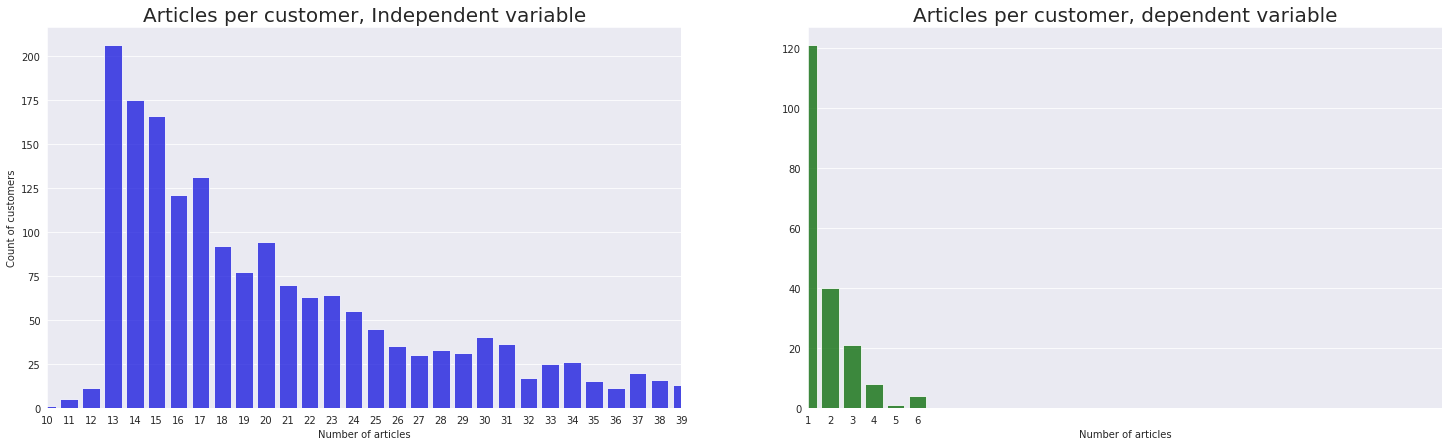

In [26]:
# Histogram --> articles/transactions per person , one person how many articles
articles_index_x = X_analyses.groupby('customer_id').size().reset_index()
articles_index_y = y_analyses.groupby('customer_id').size().reset_index()

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,7))
ax1.set_title("Articles per customer, Independent variable",fontsize=20)
sns.countplot(x = 0, data = articles_index_x, ax = ax1, color='blue', alpha=0.8)
ax1.set_xlabel('Number of articles')
ax1.set_ylabel('Count of customers')
ax1.set(xlim=(0, 29))

ax2.set_title("Articles per customer, dependent variable",fontsize=20)
sns.countplot(x = 0, data = articles_index_y, ax = ax2, color='green', alpha=0.8)
ax2.set_xlabel('Number of articles')
ax2.set_ylabel('')
ax2.set(xlim=(0, 29))

plt.show()

The majority of customers have bought 1 product only, with the histogram showing a strong right skewed distribution across both data sets.

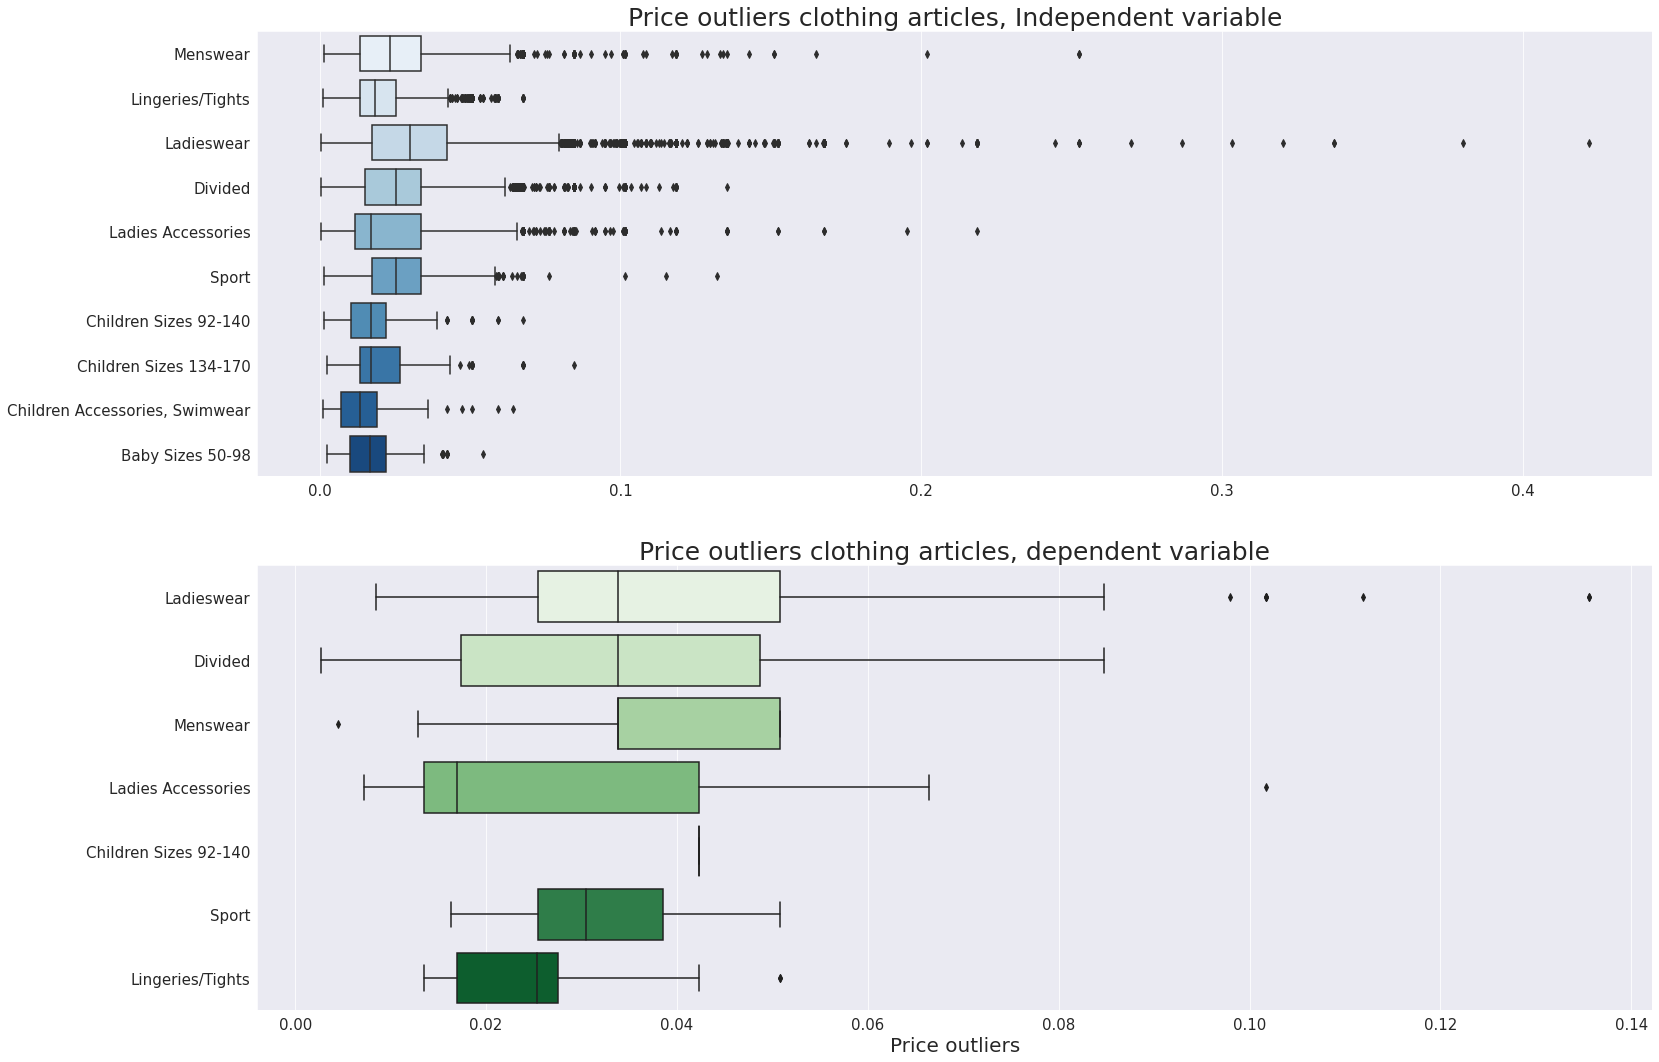

In [27]:
# Outliers boxplot Articles

sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25,18))

sns.boxplot(data=X_analyses, ax=ax1, x='price', y='index_name', palette ='Blues')
ax1.set_xlabel('')
ax1.set_ylabel('', fontsize=20)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.set_title("Price outliers clothing articles, Independent variable", fontsize=25)

sns.boxplot(data=y_analyses, ax=ax2, x='price', y='index_name', palette ='Greens')
ax2.set_xlabel('Price outliers', fontsize=20)
ax2.set_ylabel('')
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.set_title("Price outliers clothing articles, dependent variable", fontsize=25)

plt.show()

We see outliers for certain clothing articles, e.g. ladieswear & menswear have large price variances. This could be explained by the existance of unique collections, relative to casual ones. The Dividend Collection for example, does not have a price variance that high.

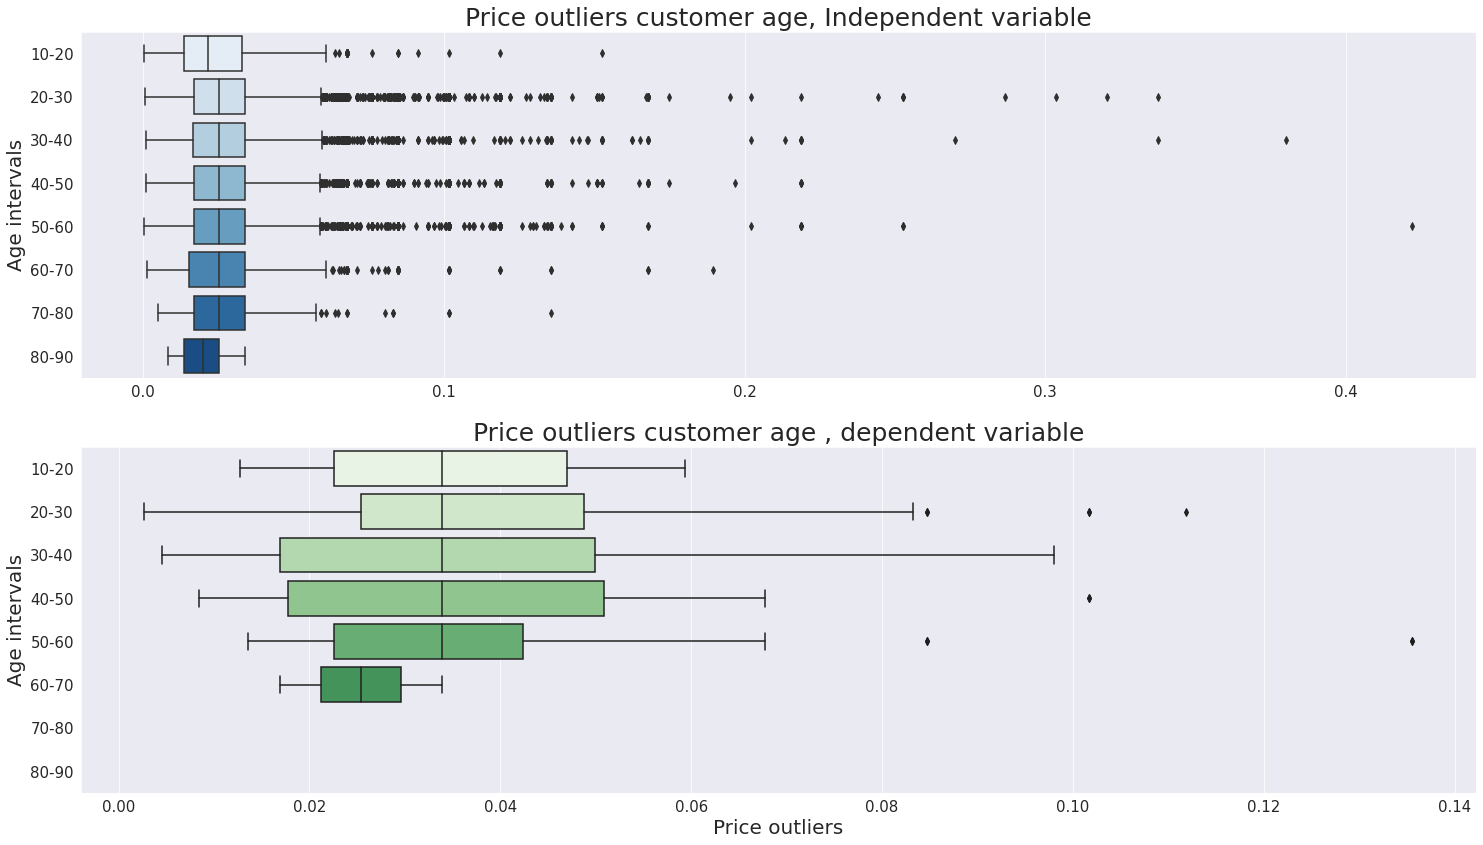

In [28]:
# Outliers boxplot Customers Age bins

sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25,14))

sns.boxplot(data=X_analyses, ax=ax1, x='price', y='age_interval', palette ='Blues')
ax1.set_xlabel('')
ax1.set_ylabel('Age intervals', fontsize=20)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.set_title("Price outliers customer age, Independent variable", fontsize=25)

sns.boxplot(data=y_analyses, ax=ax2, x='price', y='age_interval', palette ='Greens')
ax2.set_xlabel('Price outliers', fontsize=20)
ax2.set_ylabel('Age intervals', fontsize=20)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.set_title("Price outliers customer age , dependent variable", fontsize=25)

plt.show()

In terms of age, we have outliers across all age bins, however both independent and dependet set have the same structure, which therefore does not affect the model performance.

In [29]:
dt_seasonality = df_transactions_load.sort_values("t_dat").groupby(pd.to_datetime(df_transactions_load['t_dat']).dt.strftime('%b-%Y'), sort=False).size()

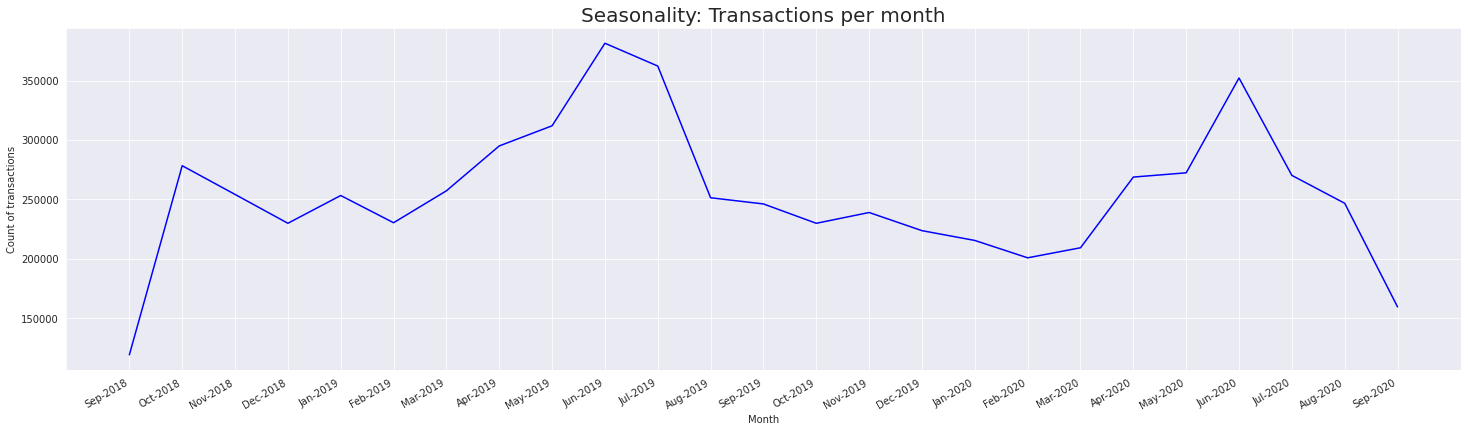

In [30]:
# Seasonality across full dataset
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(25,7))
ax = sns.lineplot(data=dt_seasonality, color='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Count of transactions')
plt.title("Seasonality: Transactions per month",fontsize=20)
f.autofmt_xdate()
plt.show()

In terms of seasonality, we can clearly see a higher number of transactions in the summer months of June/July of each year.

------

## **<span id="Models" style="color:#023e8a;">3. Models</span>**

We built **different types of Recommender Systems** and make a comparison between them to see which one has the best evaluation score, i.e., which one would be the best to use in order to solve H&M business problem and predict the 10 items that customers will potentialy buy in the next 7 days. 

See in the list below the models we built: 

####  [<span style="color:#023e8a;">1. Content_based_filtering </span>](#Content_based_filtering)

#### [<span style="color:#023e8a;">2. Collaborative_filtering </span>](#Collaborative_filtering)
    
   [<span style="color:#023e8a;">2.1 Collaborative_filtering_user-item </span>](#Collaborative_filtering_user-item)
   
   [<span style="color:#023e8a;">2.2 Collaborative_filtering_item-item </span>](#Collaborative_filtering_item-item)

#### [<span style="color:#023e8a;">3. Kmeans_Clustering </span>](#Kmeans_Clustering) 

#### [<span style="color:#023e8a;">4. Popularity_recommender </span>](#Popularity_recommender)

#### [<span style="color:#023e8a;">5. Neural_network_recommendation_system </span>](#Neural_network_recommendation_system)

#### [<span style="color:#023e8a;">6. LighFM_recommendation_system </span>](#LightFM)

#### [<span style="color:#023e8a;">7. Hybrid_model_recommendation_system </span>](#Hybrid_model_recommendation_system)

----


#### **<span id="Content_based_filtering" style="color:#023e8a;">1. Content_based_filtering</span>**

**Description of the model**

A content-based recommender system is built with the aim of recommending items to customers based on their preferences. For instance, if there are four items, and if customer X has purchased the first two, and if Item 3 is similar in terms of features to Item 1, then the content-based system will recommend Item 3 to the customer. The whole **process is based on the similarity between the items purchased by the different customers**. 

👍 **Pros** 

This model does not require an extensive transactions or like history. It is also possible to recommend new items that have not been frequently bought before.

👎 **Cons**

It does not apply when there are items whose features have never been similar to the items the user already purchased. Therefore, the recommender system will never recommend any item with all features different from the items that the user has already purchased. This is why, besides Content-based recommender system, we investigated other approaches too. 


In [31]:
def create_features(df, features):
    '''
    Create a new column in dataframe as a join of the feature columns
    '''
    temp_df = pd.DataFrame(df)
    return temp_df.iloc[:,features].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1)

def create_df_for_sim(matrix, df_index):
    '''
    Returns a dataframe with the cosine similarity matrix and corresponding index
    '''
    # Matrix of article x article
    cos_sim_article_content = pd.DataFrame(cosine_similarity(
        matrix.astype(np.float16)),
        index=df_index, columns=df_index)
    return cos_sim_article_content

##### 1.1 Article

In [32]:
def create_article_df(df):
    '''
    Merges the articles dataset with the extra features of the transactions dataset
    '''
    df_buying = df.groupby(['article_id']).agg({'price':'sum','t_dat':'count'}).rename(columns={'price': 'price_spend', 't_dat':'nr_items_bought'})
    return df_articles.join(df_buying, on='article_id')

enrich_df_article = FunctionTransformer(create_article_df, validate=False)
create_features_df = FunctionTransformer(create_features, kw_args={'features':[5,15,17,21,24]}, validate=False) # ONly the important features fot the Vectorizer
create_df_from_matrix = FunctionTransformer(create_df_for_sim, kw_args={'df_index':df_articles.article_id}, validate=False)

# Building the pipeline 
model_pipeline = Pipeline(steps=[
    ('enrich_df', enrich_df_article),
    ('create_features', create_features_df),
    ('count_article', CountVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(n_components=205, random_state=42)),
    ('create_df', create_df_from_matrix)
    ],verbose=True)
cos_sim_article_content = model_pipeline.fit_transform(X)

print("Total percentage of variance explained;", model_pipeline.named_steps['svd'].explained_variance_ratio_.sum()) # This matches 90%

[Pipeline] ......... (step 1 of 5) Processing enrich_df, total=   0.1s
[Pipeline] ... (step 2 of 5) Processing create_features, total=   4.5s
[Pipeline] ..... (step 3 of 5) Processing count_article, total=   0.5s
[Pipeline] ............... (step 4 of 5) Processing svd, total=   2.8s
[Pipeline] ......... (step 5 of 5) Processing create_df, total=   5.7s
Total percentage of variance explained; 0.9054410606920773


##### 1.2 Customers 

In [50]:
def create_customer_df(df):
    '''
    Merges the customers dataset with the extra features of the transactions dataset
    '''
    df_buying = df.groupby(['customer_id']).agg({'price':'sum','t_dat':'count'}).rename(columns={'price': 'price_spend', 't_dat':'nr_items_bought'})
    return df_customers.join(df_buying, on='customer_id')

def make_bins_of_features(features):
    '''
    Creates 4 bins for every feature of the features list
    '''

    for i in range(features.shape[1]):
        features[:,i] = pd.qcut(features[:,i], 4, labels=False, duplicates='drop')
    return features

def values_to_words(df, features):
    '''
    Create a string from the bins created for the CountVectorizer
    '''
    for i, feature in enumerate(features):
        df[:,i][df[:,i]==0] = f"{feature}_small"
        df[:,i][df[:,i]==1] = f"{feature}_mid_small"
        df[:,i][df[:,i]==2] = f"{feature}_mid_big"
        df[:,i][df[:,i]==3] = f"{feature}_big"
    return df

enrich_df_customer = FunctionTransformer(create_customer_df, validate=False)
create_features_df = FunctionTransformer(create_features, kw_args={'features':[0,1,2,6,7,8]}, validate=False) # Only use appropriate features
create_df_from_matrix = FunctionTransformer(create_df_for_sim, kw_args={'df_index':df_customers.customer_id}, validate=False)
create_bins_of_features = FunctionTransformer(make_bins_of_features, validate=False)
map_values_to_words = FunctionTransformer(values_to_words, kw_args={"features":["age", "price_spend", "nr_items_bought"]}, validate=False)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('bin_splitter', create_bins_of_features),
])

preprocessor = ColumnTransformer(
        transformers=[('bins_splitting', numeric_transformer,
                       ["age", "price_spend", "nr_items_bought"])], remainder="passthrough") # Pass all attributes that are not listed

model_pipeline = Pipeline(steps=[
    ('enrich_df', enrich_df_customer),
    ('preprocessing_num_cols', preprocessor),
    ('map_values', map_values_to_words),
    ('create_features', create_features_df),
    ('count_article', CountVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(n_components=1200, random_state=42)), # n_components are based on variance explained
    ('create_df', create_df_from_matrix)
    ],verbose=True)
cos_sim_customer_content = model_pipeline.fit_transform(X)

print("Total percentage of variance explained;", model_pipeline.named_steps['svd'].explained_variance_ratio_.sum()) # This matches 90%

[Pipeline] ......... (step 1 of 7) Processing enrich_df, total=   0.0s
[Pipeline]  (step 2 of 7) Processing preprocessing_num_cols, total=   0.0s
[Pipeline] ........ (step 3 of 7) Processing map_values, total=   0.0s
[Pipeline] ... (step 4 of 7) Processing create_features, total=   0.4s
[Pipeline] ..... (step 5 of 7) Processing count_article, total=   0.0s
[Pipeline] ............... (step 6 of 7) Processing svd, total=   3.7s
[Pipeline] ......... (step 7 of 7) Processing create_df, total=   0.2s
Total percentage of variance explained; 0.8983131744863471


------

#### **<span id="Collaborative_filtering" style="color:#023e8a;">2. Collaborative_filtering</span>**

We can distinguish between two types of Collaborative filtering models: **user-item model** or **item-item model**.
 
 See in the sections below, the two CF models.

👍 **Pros of Collaborative filtering**

Collaborative filtering does not require any knowledge about the industry as it just finds the connections based on the purchase history. It also does not require any meta data about the users or the articles.
 
👎 **Cons of Collaborative filtering**

Main shortcomings of CF: data sparsity, cold start and scalability. 

Data sparsity happens when, like in our case, you have a large dataset of users who generally purchase only a limited number of items. As we have seen above, collaborative based recommendation system can only predict scoring of an item if there are other users who have rated it / bought it. 

Cold start refers to the difficult that this system might have when there is a new user, and as such a profile doesn’t exist for them yet. Cold start can also happen when we have a new item which has not received a rating. 

Finally, another shortcoming can be related to scalability. If the number of users or items increases and the amount of data expands, collaborative filtering algorithms might drop in performance simply because of the growth and the similarity computation. 

#####  <span id="Collaborative_filtering_user-item" style="color:#023e8a;">2.1 Collaborative_filtering_user-item</span>

**Description of the model**
 
A user-item filtering will take a particular user, find users that are similar to that user based on the similar purchase history of the customers. It will then recommen articles that similar customers have already bought.

In [34]:
#User-item model

def create_purchase_user_df(df):
    """
    Merges the customers dataset with the extra features of the transactions dataset
    """
    df_purchases = df.groupby(["customer_id", "article_id"], as_index=False).sales_channel_id.count().rename(columns={"sales_channel_id":"quantity"})
    return df_customers[["customer_id"]].merge(df_purchases, on='customer_id', how='left').drop_duplicates().fillna(0)

def create_customer_article_matrix(df):
    '''
    Returns the similarity matrix with the amount of purchases as values
    '''
    customer_article_matrix = df.set_index(['customer_id','article_id'])['quantity'].unstack().fillna(0)
    user_item_similarity_matrix = pd.DataFrame(cosine_similarity(customer_article_matrix.astype(np.float16)),
                                               index=customer_article_matrix.index,
                                               columns=customer_article_matrix.index)
    return user_item_similarity_matrix

create_purchase_df = FunctionTransformer(create_purchase_user_df, validate=False)
create_user_similarity_matrix = FunctionTransformer(create_customer_article_matrix, validate=False)

model_pipeline = Pipeline(steps=[
    ('create_purchase_df', create_purchase_df),
    ('create_user_similarity_matrix', create_user_similarity_matrix)],verbose=True)
cos_sim_customer_collab = model_pipeline.fit_transform(X)

[Pipeline]  (step 1 of 2) Processing create_purchase_df, total=   0.1s
[Pipeline]  (step 2 of 2) Processing create_user_similarity_matrix, total=   3.6s


##### <span id="Collaborative_filtering_item-item" style="color:#023e8a;">2.2 Collaborative_filtering_item-item</span>
 
 **Description of the model**
 
Item-item filtering model takes an item and finds items that were purchased similarily often and for the same price. It then recommends items to users that are similar to the ones that user has already bought. 
It takes items and outputs other items as recommendations.

In [35]:
def create_purchase_item_df(df):
    return df.groupby(["customer_id", "article_id"], as_index=False).sales_channel_id.count().rename(columns={"sales_channel_id":"quantity"})

def create_article_article_matrix(df):
    '''
    this returns the article similarity matrix
    '''
    customer_article_matrix = df.set_index(['customer_id','article_id'])['quantity'].unstack().fillna(0)
    item_item_similarity_matrix = pd.DataFrame(cosine_similarity(customer_article_matrix.T.astype(np.float16)),
                                               index=customer_article_matrix.T.index,
                                               columns=customer_article_matrix.T.index)
    return item_item_similarity_matrix

create_purchase_df = FunctionTransformer(create_purchase_item_df, validate=False)
create_article_similarity_matrix = FunctionTransformer(create_article_article_matrix, validate=False)

model_pipeline = Pipeline(steps=[
    ('create_purchase_df', create_purchase_df),
    ('create_article_similarity_matrix', create_article_similarity_matrix)],verbose=True)
cos_sim_article_collab = model_pipeline.fit_transform(X)

[Pipeline]  (step 1 of 2) Processing create_purchase_df, total=   0.1s
[Pipeline]  (step 2 of 2) Processing create_article_similarity_matrix, total=  35.5s


------

 #### **<span id="Kmeans_Clustering" style="color:#023e8a;">3. Kmeans_Clustering</span>**

**Description of the model**

Useful algortithm that allows us to characterize and categorize data if we don’t really know how to separate it before hand. Splitting the customers into multiple clusters allows us to generate a popularity model for each cluster and therefore leverage a very easy model with personalized features.

👍 **Pros**

It allows to approach a domain without really knowing a whole lot about it, and draw conclusions and even design a useful application around it

It is relatevely easy to implement and scale well with large datasets

It can easily adapt to new examples (fix the problem of the Content-based system we saw above).

 
👎 **Cons**

We have to choose the k manually, that can lead us to some mistakes

It can have troubles when where clusters are of varying sizes and density

We need to be careful with outliers, indeed centroids can be dragged by outliers, or outliers might get their own cluster instead of being ignored.

In [36]:
enrich_df_customer = FunctionTransformer(create_customer_df, validate=False)

cat_transformer = Pipeline(steps=[
    ('imputing_cats',SimpleImputer(strategy='most_frequent')),
    ('onehot_cats',OneHotEncoder(handle_unknown = 'ignore',sparse=False))])

num_transformer = Pipeline(steps=[
    ('imputing_nums',SimpleImputer(strategy = 'mean')),
    ('scaling_nums',StandardScaler())])

preprocessing = ColumnTransformer(transformers=[
    ('cat_transf',cat_transformer,["club_member_status", "fashion_news_frequency", "postal_code"]),
    ('num_transf',num_transformer,["FN", "Active", "age", "price_spend", "nr_items_bought"])], remainder="drop")

clustering = Pipeline(steps=[
    ('merge_customers', enrich_df_customer),
    ('preprocessing',preprocessing),
    ('kmeans',KMeans(n_clusters=10)),
    ],verbose=True)
cluster = clustering.fit_predict(X) # Predicting the correct cluster


def get_top_articles(row):
    """
    Return top 15 articles for every cluster
    """
    return X[X["customer_id"].isin(row.customer_id)].article_id.value_counts().index[:15].tolist()

users_cluster = pd.DataFrame(np.concatenate((unique_customers.reshape(-1,1), cluster.reshape(-1,1)), axis = 1), columns = ['customer_id', 'cluster']) # Clusters and customers in dataframe
users_clusters_grouped = users_cluster.groupby("cluster")["customer_id"].apply(list).reset_index() # customers as list per cluster
users_clusters_grouped["top_articles"] = users_clusters_grouped.apply(lambda x: get_top_articles(x), axis=1, result_type="reduce") # receive list of top articles
users_clusters_explode = users_clusters_grouped.explode("customer_id") # Customer from list to individual row
users_clusters_explode.set_index("customer_id", inplace=True, verify_integrity=True) # Customers as index for faster indexing later

[Pipeline] ... (step 1 of 3) Processing merge_customers, total=   0.1s
[Pipeline] ..... (step 2 of 3) Processing preprocessing, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing kmeans, total=   2.5s


#### **<span id="Popularity_recommender" style="color:#023e8a;">4. Popularity_recommender</span>**

**Description of the model**

Popularity based recommendation system works with the trend. It uses the items which are in trend right now. For instance, a product that is usually purchased by each new user will then be suggested to the user who has just signed up. It also functions as a baseline model in our case as this is the easiest and least personalized model.

👍 **Pros**

This model can be useful if we are having new customers or customers who have not bought something yet so we dont have any information about their preferences. 
 
 👎 **Cons**
 
The problems with popularity based recommendation system is that the personalization is not available with this methodm, i.e., even though you know the behaviour of the user you cannot recommend items accordingly.

In [37]:
df_articles_popularity = X.article_id.value_counts().reset_index().rename(columns={"index":"article_id", "article_id":"count"})

 #### **<span id="Neural_network_recommendation_system" style="color:#023e8a;">5. Neural_network_recommendation_system</span>**

**Description of the model**

We are using a tensorflow recommender system retrieval here. The reason we are using it, that the retrival model will select only the most similar articles. 

The architecture is a two-tower retrival model which are build seperately and then combined in the final model. One tower is for the customer, the other for the article.

To evaluate our model we are using FactorizeTopK. The reason for that ist that our data has positive(customer,article) pairs (if there is a transaction). To find out how good the model is we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible articles. If the score for the positive pair is higher than for all other candidates the model is accurate.

We also need to consider the loss. TFRS has several loss layers. We will make use of the Retrieval task object: a  wrapper that bundles together the loss function and metric computation.

In our class we put the whole model together. The tfrs.models.Model streamlines everything since we only need to  set up the components in the _init_ method, and implement the compute_loss method, taking in the raw features and returning a loss value. The tfrs Model also computes both traning and test losses.

**Outcome**
As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. In our case, a top-12 categorical accuracy metric of 0.02 would tell us that, on average, the true positive is in the top 12 retrieved items 2% of the time.

👍 **Pros**
Computationally efficient
The main objective of this model is to efficiently excludes out all products that the user is not interested in 
 
 👎 **Cons**
 Overfitting. Out model is likely to perform better on the data that it has seen, simply because it can memorize it. Since we have also many parameters, this is a real issue, but can be regulated by regularization or features that help the model generalize better to unseen data. 
 
Furthermore the model is re-recommending some of users' already bought items. These known-positive items can crowd out test items out of top 12 recommendation

In [38]:
#We need to map the raw values of our features to embedding vectors in our models. 
#To do that, we need a vocabulary that maps a raw feature value to an integer in a 
#contiguous range: this allows us to look up the corresponding embeddings in our embedding tables.
unique_customer_ids = df_customers.customer_id.unique()
unique_article_ids = df_articles.article_id.unique()

# create shells for the model
unique_products_ds = tf.data.Dataset.from_tensor_slices(unique_article_ids)
article_ds = tf.data.Dataset.from_tensor_slices(dict(df_articles[['article_id']]))
articles = article_ds.map(lambda x: x['article_id'])

embedding_dimension = 64
#Higher values will correspond to models that may be more accurate, 
#but will also be slower to fit and more prone to overfitting.

# Query Model we are building two sequential models here, one for customer and
# one for articles. First we are doing for each the preprocessing with a stringLookup
# to convert user ids to integers 
# next step is the embedding layer here we embedd the unique user IDs
# we do the same for articles 
# Customer model
customer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_customer_ids, mask_token=None),  
  tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dimension)
])

# Article Model
article_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_article_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dimension)
])

# Retrieval Model
#Higher values will correspond to models that may be more accurate, 
#but will also be slower to fit and more prone to overfitting.


class FullModel(tfrs.Model):

  def __init__(self, customer_model, article_model):
      super().__init__()
      self.article_model: tf.keras.Model = article_model
      self.customer_model: tf.keras.Model = customer_model
      self.task = tfrs.tasks.Retrieval(
      metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.article_model),            
            ),
        )   

  def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
    
      customer_embeddings = self.customer_model(features["customer_id"])    
      article_embeddings = self.article_model(features["article_id"])

        # The task computes the loss and the metrics.
      return self.task(customer_embeddings, article_embeddings,compute_metrics=not training)

#instantiate the model
model = FullModel(customer_model, article_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05))

# define train test and shuffle, batch and cache the training set 
train = X
test = y

train_ds = tf.data.Dataset.from_tensor_slices(dict(train[['customer_id','article_id']])).shuffle(100_000).batch(256).cache()
test_ds = tf.data.Dataset.from_tensor_slices(dict(test[['customer_id','article_id']])).batch(256).cache()

# fit and train the model
num_epochs = 5
model.fit(
    train_ds,    
    epochs=num_epochs,
    verbose=1)


# Making predictions with factorized top_k Brute Forece
# Create a model that takes in raw features --> takes our customer model
index = tfrs.layers.factorized_top_k.BruteForce(model.customer_model)
# and recommends articles out of the entire article dataset for the customers
index.index_from_dataset(
    unique_products_ds.batch(100).map(lambda article_id: (article_id, model.article_model(article_id))))


customer_id_list = list(unique_customer_ids) # includes all product numbers
#create the dataframe for each customer to recommend them the top 12 products
dict_all = {}
for customer in customer_id_list:
  dict_all[customer]= [] 
  #change from tensorflow to numpy and then from bytes type to integer
  _, products = index(np.array([customer]))
  products_small = products[0, :12].numpy()
  products_small = products_small.astype(int)
  dict_all[customer].extend(products_small) 

neural_recommendation = df_transactions.groupby(['customer_id']).last()[['article_id']].rename({'article_id':'last_article'})
neural_recommendation['recommend_by_item_item'] = neural_recommendation.index.map(dict_all) 

Epoch 1/5
175/175 [==============================] - 3s 5ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1409.5138 - regularization_loss: 0.0000e+00 - total_loss: 1409.5138
Epoch 2/5
175/175 [==============================] - 1s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1359.7486 - regularization_loss: 0.0000e+00 - total_loss: 1359.7486
Epoch 3/5
175/175 [==============================] - 1s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - facto

 #### **<span id="LighFM_recommendation_system" style="color:#023e8a;">6. LightFM</span>**

**Description of the model**


LightFM is a hybrid factorization model being able to recommend  for both implicit and explicit feedback types. Its outcome is a hybrid recommendation. It represents user and articles as a linear combination of their content features latent factors. 

Users and items are represented as latent vectors, meaning that users and items are represented with their features, and for each feature an embedding is done. The model learns then the embeddings in a way that encodes users preferences over items. The representations of the features are multiplied together producing scores for every item for a user. The items with the highest score, are more likely to be interesting to the users.


Our LightFM model is using the weighted Approximate-Rank Pairwise (WARP) as the loss.It maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present. Since we are only having postive representations ( transaction yes/ no), this fits best for us.

👍 **Pros**

It works well in cold-start and low density scenarios

It works well with big data sets

In [39]:
EPOCHS = 25

dataset = Dataset()
dataset.fit(users=df_customers['customer_id'], items=df_articles['article_id']) # Build Sparse Matrix of customers and articles

(interactions, weights) = dataset.build_interactions(X.iloc[:, 1:3].values) # Fill values with the transactions history for X
(val_interactions, val_weights) = dataset.build_interactions(y.iloc[:, 1:3].values) # Fill values with the transactions history for y

model = LightFM(loss='warp', no_components=50, 
                 learning_rate=0.2,                 
                 random_state=np.random.RandomState(42))
model.fit(interactions=interactions, epochs=EPOCHS, verbose=1)

uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping() # Retract individual components from the dataset

inv_uid_map = {v:k for k, v in uid_map.items()} # Create inverse dictionary to reference key later
inv_iid_map = {v:k for k, v in iid_map.items()}

all_customers = df_customers.customer_id.values
# lfn_user = lambda x: uid_map[x]
cust_vals = [uid_map[tx] for tx in all_customers] # Get values for all customers

customer_ids = []
preds = []

vals =  np.array(list(iid_map.values()))
for usr_ in tqdm.tqdm(cust_vals, total = len(cust_vals)):
    m_opt = model.predict(np.array([usr_] * len(iid_map)),vals) # Predict values
    pred = np.argsort(-m_opt)[:15] # Get index of top 15 values
    customer_ids.append(inv_uid_map[usr_])
    preds.append([inv_iid_map[p] for p in pred]) # Get the articles of the predicted values
light_fm_recommender = pd.DataFrame({'customer_id':customer_ids, 'prediction': preds}).set_index("customer_id")

100%|██████████| 1891/1891 [00:14<00:00, 133.30it/s]


#### **<span id="Hybrid_model_recommendation_system" style="color:#023e8a;">7. Hybrid Model</span>**

**Description of the model**

Hybrid recommender system combines both content and collaborative filtering method. You can implement in in different ways, we implemented it by creating one content and one collaberative model and then combining them, by adding them.  This can be more effective in some cases and some studies say, that they are combined more accurate.

This hybrid model is a mixed hybrid model. For one two similarity scores are being counted togehter to create a new model. On the other hand, the collaborative filtering model of article-article is used, if no customers can be found. Therefore both parts of this hybrid model interact to form one big model.

👍 **Pros**

These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.


In [40]:
cos_sim_hybrid_customer = pd.DataFrame((cos_sim_customer_collab.values + cos_sim_customer_content.values), index=cos_sim_customer_collab.index, columns=cos_sim_customer_collab.columns)
cos_sim_hybrid_article = cos_sim_article_collab

### **<span id="Recommendation" style="color:#023e8a;">Recommendation</span>**

In [41]:
def get_predictions_article(article, cos_sim_matrix):
    """
    Get the predictions for a specific article and cosine similarity matrix by indexing the article in the matrix
    """
    predictions = cos_sim_matrix.loc[article].sort_values(ascending=False).index.values
    return predictions[~np.isin(predictions, article)][:15]

def get_predictions_customer(customer, cos_sim_matrix):
    """
    Get the predictions for a specific customer and cosine similarity matrix by indexing the customer in the matrix
    """
    try:
        similar_customers = cos_sim_matrix.loc[customer].sort_values(ascending=False).index.values
    except KeyError:
        return []
    articles = []
    for customer in similar_customers: # Get the articles of the customers that already have a purchase history
        try:
            articles.extend(df_customer_article_X.loc[customer, df_customer_article_X.loc[customer] != 0].index.values)
        except KeyError:
            continue     
        if len(articles) >= 14: # Stop when 14 iteam are alrady in the list
            break
    return articles[:15]

def get_prediction_kmeans(customer, df):
    """
    Top 15 values of kmeans by custoer
    """
    return df.loc[customer, "top_articles"][:15]

def get_prediction_lightfm(customer, df):
    """
    Returns the prdiciton value for a specific customer
    """
    return df.loc[customer, "prediction"]

def get_prediction_neural_network(customer, df):
    """
    Returns the prdiciton value for a specific customer
    """
    return df.loc[customer, "recommend_by_item_item"]

def get_predictions_popularity():
    """
    Get 15 most popular items
    """
    return df_articles_popularity.article_id.values[:15]

In [42]:
df_predictions = pd.DataFrame({"customer_id":[],
                               "actual":[],
                               "predictions_content_based_article":[],
                               "predictions_content_based_customer":[],
                               "predictions_collaborative_filter_article":[],
                               "predictions_collaborative_filter_customer":[],
                               "predictions_hybrid":[],
                               "predictions_kmeans":[],
                               "predictions_light_fm":[],
                               "predictions_neural_network":[],
                               "predictions_popularity":[]})

print("Total number of iterations:", df_customers.customer_id.nunique()) # Showing how many total iterations to process
iterations = 0 # Counting the number of iterations in upcoming for loop

timing = int((df_customers.customer_id.nunique()/4)) # Show number of iterations 4 times

for customer in df_customers.customer_id.unique(): # Go over every customer in the customer_df
    if iterations % timing == 0:
        print("Nr of iterations:", iterations)
        
    try:
        actual_articles = [df_customer_article_y.loc[customer, df_customer_article_y.loc[customer] != 0].index.values] # Get all articles the customer bought in the y data set
    except KeyError: # If customer has no purchases in the y data set, ignore this customer
        iterations += 1
        continue
    
    # Get predictions for all models
    try:
        last_article = df_last_articles.loc[customer].article_id
        predictions_content_based_article = get_predictions_article(last_article, cos_sim_article_content)
        predictions_collaborative_filter_article = get_predictions_article(last_article, cos_sim_article_collab)
        predictions_hybrid = get_predictions_article(last_article, cos_sim_hybrid_article)
    except KeyError:
        predictions_content_based_article = []
        predictions_collaborative_filter_article = []
        predictions_hybrid = get_predictions_customer(customer, cos_sim_hybrid_customer)
    
    predictions_content_based_customer = get_predictions_customer(customer, cos_sim_customer_content)
    predictions_collaborative_filter_customer = get_predictions_customer(customer, cos_sim_customer_collab)
    predictions_popularity = get_predictions_popularity()
    predictions_kmeans = get_prediction_kmeans(customer, users_clusters_explode)
    predictions_lightfm = get_prediction_lightfm(customer, light_fm_recommender)
    predictions_neural_network = get_prediction_neural_network(customer, neural_recommendation)

    temp_df = pd.DataFrame({"customer_id":[customer],
                            "actual":actual_articles,
                            "predictions_content_based_article":[predictions_content_based_article],
                            "predictions_content_based_customer":[predictions_content_based_customer],
                            "predictions_collaborative_filter_article":[predictions_collaborative_filter_article],
                            "predictions_collaborative_filter_customer":[predictions_collaborative_filter_customer],
                            "predictions_hybrid":[predictions_hybrid],
                            "predictions_kmeans":[predictions_kmeans],
                            "predictions_light_fm":[predictions_lightfm],
                            "predictions_neural_network":[predictions_neural_network],
                            "predictions_popularity":[predictions_popularity],
                            })
    df_predictions = pd.concat([df_predictions, temp_df], ignore_index=True)
    
    iterations += 1

Total number of iterations: 1891
Nr of iterations: 0
Nr of iterations: 472
Nr of iterations: 944
Nr of iterations: 1416
Nr of iterations: 1888


------

## **<span id="Evaluation_Metrics" style="color:#023e8a;">4. Evaluation_Metrics</span>**

In this section, you will find the following evaluation metrics and, at the endat the end an evaluation dataframe comparing the different evaluation metrics computed on all the models built above.

*   [<span style="color:#023e8a;">1 Mean_Average_Precision </span>](#Mean_Average_Precision)
*   [<span style="color:#023e8a;">2 Mean_Average_Recall </span>](#Mean_Average_Recall)
*   [<span style="color:#023e8a;">3 Novelty </span>](#Novelty)
*   [<span style="color:#023e8a;">4 Coverage </span>](#Coverage)
*   [<span style="color:#023e8a;">Evaluation_dataframe </span>](#Evaluation_dataframe)


 #### **<span id="Mean_Average_Precision" style="color:#023e8a;">1. Mean_Average_Precision</span>**

With the following function, we compute the average precision at k betweeen the inputs list. This metric comprises how relevant the list of recommended items are. Based on how early an article is predicted that is in the list of the articles the customer later bought, the better the score. The intention of the ,metric is to show, if the recommender only recommendes relevant items.

Inputs list: 

-> actual: a list of elements that are to be predicted (order doesn't matter)

-> predicted: a list of predicted elements (order does matter)

-> k: (set it manually) 10 in this case that refers to the maximum number of elements we want to predict 


In [43]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if len(actual) < 1:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

 #### **<span id="Mean_Average_Recall" style="color:#023e8a;">2. Mean_Average_Recall</span>**

We use the same function, but here we compute the recall instead of precision. This metric ives insight into how well the recommender is able to recall all the items the user has pruchased. Here, also the earlier the correct article is recommended, the higher the score. The difference with this metric is to show if the recommender can predict all the relevant items of the user.

In [44]:
def ark(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if len(actual) < 1:
        return 0.0

    return score / len(actual)

def mark(actual, predicted, k=10):
    return np.mean([ark(a,p,k) for a,p in zip(actual, predicted)])

 #### **<span id="Novelty" style="color:#023e8a;">3. Novelty</span>**

With the following function, we calculate the novelty for a list of recommendations. Novelty meassures how different the predictions are from one another. The less popular an article is, the higher the novelty score for recommending it, as this metric is there to measure if the recommender system can show new articles to the customer that he has probably not seen before.

Inputs: 

-> predicted: a list of ordered predictions 

-> pop: dictionary of all items alongside of its occurrences counter in the training data

-> u: integer - the number of users in the training data

-> n: integer - the lenght of recommended lists per users 

In [45]:
def novelty(predicted, pop, u, n,):
    mean_self_information = []
    k = 0
    try: 
        for sublist in predicted:
            self_information = 0
            k += 1
            for i in sublist:
                self_information += np.sum(-np.log2(pop[i]/u))
            mean_self_information.append(self_information/n)
        novelty = sum(mean_self_information)/k
        return novelty
    except KeyError:
      return 0.0

 #### **<span id="Coverage" style="color:#023e8a;">4. Coverage</span>**

In the next cell, we use the prediction_coverage function in order to compute the prediction coverage for a list of recommendations parameters. Here we calculate the percentage of all possible articles that are predicted by the algorithm. This gives an idea of how many different items are predicted and how quickly a new item will appear in the recommendation list.


Inputs:

-> predicted: list of ordered predictions

-> catalog: a list of all unique items in the training data 

In [46]:
def prediction_coverage(predicted, catalog):
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
    return prediction_coverage

### **<span id="Evaluation_dataframe" style="color:#023e8a;">Evaluation_dataframe</span>**

In [47]:
def add_eval(metrick, predictions):
    """
    Calculates scores for the metric at k
    """
    metric, k = metrick.split("@")
    k = int(k)
    if metric == "MAP":
        return mapk(df_predictions.actual, predictions, k)
    elif metric == "MAR":
        return mark(df_predictions.actual, predictions, k)
    elif metric == "Novelty":
        return novelty(predictions, df_transactions["article_id"].value_counts().to_dict(),df_transactions.customer_id.nunique(), k)
    elif metric == "Coverage":
        return prediction_coverage([pred[:k] for pred in predictions], df_articles.article_id.unique())
    return np.random.randint(10,100)


model_dict = {
              "Content Based (Article)": df_predictions.predictions_content_based_article,
              "Content Based (Customer)": df_predictions.predictions_content_based_customer,
              "Collab. Filtering (Article)": df_predictions.predictions_collaborative_filter_article,
              "Collab. Filtering (Customer)": df_predictions.predictions_collaborative_filter_customer,
              "Hybrid":df_predictions.predictions_hybrid,
              "KMeans":df_predictions.predictions_kmeans,
              "LightFM":df_predictions.predictions_light_fm,
              "Neural Network":df_predictions.predictions_neural_network,
              "Popularity":df_predictions.predictions_popularity}

eval_metrics = ["MAP",
                "MAR",
                "Novelty",
                "Coverage"]

metrics = list(itertools.product(eval_metrics, range(12,14)))

df_evaluation = pd.DataFrame({"Metric": ["@".join([x,str(y)]) for x, y in metrics]})
for model, predictions in model_dict.items():
    df_evaluation[model] = df_evaluation.Metric.apply(lambda x: add_eval(x, predictions))

df_evaluation.style.highlight_max(subset=list(model_dict.keys()), color='lightgreen', axis=1) # Highlight best scores per Metric

,Metric,Content Based (Article),Content Based (Customer),Collab. Filtering (Article),Collab. Filtering (Customer),Hybrid,KMeans,LightFM,Neural Network,Popularity
0,MAP@12,0.001954,0.005361,0.001026,0.005361,0.001026,0.000000,0.000000,0.000000,0.000285
1,MAP@13,0.001954,0.005756,0.001026,0.005756,0.001026,0.000000,0.000000,0.000000,0.000285
2,MAR@12,0.001954,0.005361,0.001026,0.005361,0.001026,0.000000,0.000000,0.000000,0.000285
3,MAR@13,0.001954,0.005756,0.001026,0.005756,0.001026,0.000000,0.000000,0.000000,0.000285
4,Novelty@12,12.457360,11.675785,13.067105,11.666295,13.067105,8.200585,13.129575,0.000000,7.248335
5,Novelty@13,11.499102,10.777648,12.061943,10.768888,12.061943,7.569770,12.119608,0.000000,6.690771
6,Coverage@12,9.100000,9.290000,9.650000,9.290000,9.650000,0.380000,2.460000,8.430000,0.050000
7,Coverage@13,9.790000,10.020000,10.360000,10.030000,10.360000,0.410000,2.590000,8.430000,0.060000


-------

Above we can see that the models are performing very differently for the different measures. A recommendation system can have many intentions as it should convince the customer to buy a certain product. Sometimes it is useful to recommend items that are normally not purchases or makes sense to show products to customers that they are likely to buy in order to increase the revenue. Different companies use different strategies, depending on their field of industry and their current economic situation. In our case the MAP@12 is an important metric as this is the one that H&M mostly focus on.

Given that we only have historical data available,for the splitting we created a set of independent and dependent variables split by the last 7 days. Since our algorithms are trained by all features of the articles and we need these to predict all possible articles to the customers, we did not split the data into train, validation and test part.

## **<span id="Impact_analysis" style="color:#023e8a;">5. Impact_analysis</span>**

The best model of the ones above at MAP@12 was chosen to determine an Impact anlaysis for H&M. In our case the best recommendations were received from the Content based filtering (Article-Article) model. This evaluation will show the business impact of the recommendation system for the comapany. The analysis is conducted under the assumption that every purchase, which was recommended a priori bythe recommendation system was done due to the recommendation. Therefore any purchases by chance are not accounted for.

In [48]:
# Retrieve top column and predictions of evaluation
best_model = df_evaluation.set_index("Metric").loc["MAP@12"].idxmax() # Get best model for the evaluation of "MAP@12"
index_no = df_evaluation.columns.get_loc(best_model) + 1 # Get the column number in the pedictions of the best model (+1 as there is one more column in that df)
best_predictions = df_predictions.columns[index_no]

# Add column to indicate successful prediction
df_evaluation_per_best_model = df_predictions[["customer_id", "actual", best_predictions]].explode(best_predictions)
df_check_predictions = df_evaluation_per_best_model.explode("actual")
df_check_predictions["hit"] = df_check_predictions["actual"] == df_check_predictions[best_predictions]

# Retrieve average prices per product code
df_article_avg_price = df_transactions.groupby("article_id", as_index=False).price.mean().rename(columns={"price":"avg_price"})
df_impact_analysis = df_check_predictions.merge(df_article_avg_price, how="left", left_on="actual", right_on="article_id")

# Calculate added value as percentage of sales
impact = df_impact_analysis[df_impact_analysis["hit"]].avg_price.sum() / y.price.sum() * 100
print(f"{impact:.2f}% of the sales in the last 7 days were made because of the recommenations to the users based on the {best_model} model")

0.68% of the sales in the last 7 days were made because of the recommenations to the users based on the Content Based (Customer) model


The recommender system allows to improve H&M's top line by incentivizing customers to buy certain products. In order to do so, we extracted the correctly predicted product codes per customer and retrieved the average price for that product. In a second step, all the products and their respective prices were summed up and calculated as a proportion of sales in the same observed timeframe (from the dependent set).

In addition to the monetary winnings, there are other positive aspects of the recommendaton system as we have mentioned at the beginning. The recommender allow for an optimization in the supply chain as it can show which users will more likely buy which article. It can also help the marketing department find a strategy which customers (groups) to prioritize or deprioritize. Finally, an intangible advantage of the system is the user experience if the system would go live and the user would be prompted with the recommendations. They would feel more welcome and personalized when visiting the website.